# Olist E-commerce Customer Satisfaction Prediction Project

## Introduction
This project focuses on analyzing and predicting customer satisfaction for Olist, one of Brazil's largest e-commerce platforms. By leveraging machine learning techniques and comprehensive data analysis, we aim to develop a predictive model that can identify potential customer satisfaction issues before they materialize into negative reviews.

## Project Scope
The analysis centers on the review_score metric as our target variable, utilizing Olist's rich dataset that encompasses order details, customer information, product characteristics, and seller performance metrics. Our goal is to create a binary classification model that can effectively predict whether a customer will provide a high satisfaction rating (>=4) or not.

## Project Roadmap

### 1. Data Understanding and Preparation
- Database schema analysis and relationship mapping
- Feature identification and initial data quality assessment
- Handling missing values and outliers
- Data integration from multiple Olist tables

### 2. Exploratory Data Analysis (EDA)
- Quantitative analysis of review scores distribution
- Temporal patterns in customer satisfaction
- Correlation analysis between various features and satisfaction levels
- Product category impact on customer satisfaction

### 3. Feature Engineering
- Creation of delivery performance metrics
- Price and freight relationship features
- Temporal features extraction

### 4. Model Development
- Data preprocessing and scaling
- Implementation of various ML algorithms:
  - Random Forest
  - XGBoost
  - LightGBM
  - CatBoost
- Hyperparameter optimization using BayesSearchCV
- Model performance comparison and selection

### 5. Evaluation and Insights
- Model performance metrics analysis
- Feature importance interpretation
- Business insights extraction
- Actionable recommendations development

## Expected Outcomes
1. A robust predictive model for customer satisfaction
2. Identification of key factors influencing customer ratings
3. Actionable insights for improving customer experience
4. Early warning system for potential customer dissatisfaction
5. Recommendations for operational improvements

## Business Value
This project aims to provide Olist with:
- Proactive customer satisfaction management
- Reduced negative reviews through early intervention
- Improved operational efficiency
- Data-driven decision-making capabilities

## Technical Stack
- Python for data analysis and modeling
- Pandas & NumPy for data manipulation
- Scikit-learn for machine learning implementation
- Advanced ML libraries (XGBoost, LightGBM, CatBoost)
- Data visualization libraries (Matplotlib, Seaborn)

This comprehensive analysis will serve as a foundation for implementing data-driven strategies to enhance customer satisfaction and overall business performance.


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data acquisition and database connection
import kagglehub
import os
import pickle

# Statistical analysis
from scipy import stats

# Machine Learning models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ML preprocessing and optimization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.pipeline import Pipeline


# ML metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.makedirs('output', exist_ok=True)

In [3]:
# Download do dataset
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")  # Downloads the Brazilian e-commerce dataset from Kaggle


files = os.listdir(path)  # Gets list of all files in the downloaded dataset directory

# Creates a dictionary to store all dataframes
olist_data = {}
for file in files:
    file_path = os.path.join(path, file)  # Constructs full file path
    df_name = file.split('.')[0]  # Extracts filename without extension to use as dictionary key
    olist_data[df_name] = pd.read_csv(file_path)  # Reads CSV file into pandas DataFrame and stores in dictionary

# Prints names of all available tables
list_data = list(olist_data.keys())  # Gets list of all table names
for i in list_data:
    print(f'Table name = {i}')  # Prints each table name

Table name = olist_customers_dataset
Table name = olist_geolocation_dataset
Table name = olist_orders_dataset
Table name = olist_order_items_dataset
Table name = olist_order_payments_dataset
Table name = olist_order_reviews_dataset
Table name = olist_products_dataset
Table name = olist_sellers_dataset
Table name = product_category_name_translation


In [4]:
def data_info(df):
    """
    Creates a summary DataFrame containing information about each column in the input DataFrame.
    
    Parameters:
        df (pandas.DataFrame): Input DataFrame to analyze
        
    Returns:
        pandas.DataFrame: A DataFrame with the following columns:
            - dtypes: Data type of each column
            - Missing: Number of missing values in each column
            - Unique: Number of unique values in each column
            - Example: First value from each column
            - Entropy: Shannon entropy of value distributions (in bits)
            
    Notes:
        - Prints the shape of the input DataFrame
        - Entropy is calculated using scipy.stats.entropy with base 2
        - Higher entropy values indicate more uniform distributions
    """
    info = pd.DataFrame({
        'dtypes': df.dtypes,
        'Missing': df.isna().sum(),
        'Unique': df.nunique(),
        'Example': df.iloc[0],
        'Entropy': [round(stats.entropy(df[col].value_counts(normalize=True), base=2), 2) 
                   for col in df.columns]
    })
    
    print(f"Dataset Shape: {df.shape}")
    return info

In [5]:

df = olist_data['olist_orders_dataset'].merge(olist_data['olist_order_reviews_dataset'], on='order_id')\
                   .merge(olist_data['olist_order_payments_dataset'], on='order_id')\
                   .merge(olist_data['olist_customers_dataset'], on='customer_id')\
                   .merge(olist_data['olist_order_items_dataset'], on='order_id')\
                   .merge(olist_data['olist_products_dataset'], on='product_id')\
                   .merge(olist_data['olist_sellers_dataset'], on='seller_id')

print(f'Duplicated rows: {df.duplicated().sum()}')
data_info(df)

Duplicated rows: 0
Dataset Shape: (117329, 39)


,dtypes,Missing,Unique,Example,Entropy
order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
order_status,object,0,7,delivered,0.19
order_purchase_timestamp,object,0,97370,2017-10-02 10:56:33,16.42
order_approved_at,object,15,89533,2017-10-02 11:07:15,16.26
order_delivered_carrier_date,object,1235,80449,2017-10-04 19:55:00,16.02
order_delivered_customer_date,object,2471,95021,2017-10-10 21:25:13,16.39
order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,8.47
review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
review_score,int64,0,5,4,1.77


In [7]:
_, X_test_save, _, _ = train_test_split(df, df['review_score'], test_size=0.2, random_state=42)
X_test_save.to_csv('output/X_test_save.csv', index=False)

## Feature Engineering

### Temporal Analysis

In this code section, we perform feature engineering focused on temporal aspects of orders. The transformations can be divided into two main groups:

### 1. Time Components
We extract different components from the purchase date (`order_purchase_timestamp`):
- `purchase_year_month`: Complete period (year-month) for monthly analysis
- `purchase_year`: Purchase year
- `purchase_month`: Purchase month
- `purchase_day`: Purchase day

### 2. Time Metrics (Deltas)
We calculate the differences in days between important order events:
- `delta_approved`: Time between purchase and approval
- `delta_estimated_delivery`: Estimated delivery time
- `delta_shipping_limit`: Shipping deadline
- `delta_delivered_customer`: Actual delivery time to customer
- `delta_delivered_carrier`: Delivery time to carrier

These features are important for:
- Seasonality analysis
- Process bottleneck identification
- Logistics efficiency evaluation
- Delivery delay prediction

In [8]:
datetime_columns = ['order_purchase_timestamp', 
                    'order_approved_at', 
                    'order_delivered_carrier_date', 
                    'order_delivered_customer_date', 
                    'order_estimated_delivery_date', 
                    'review_creation_date', 
                    'review_answer_timestamp',
                    'shipping_limit_date']

# Convert to datetime and keep only the date part (YYYY-MM-DD)
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col]).dt.normalize()

df[datetime_columns].dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
shipping_limit_date              datetime64[ns]
dtype: object

In [9]:
# Extracting time components from purchase date
df['purchase_year_month'] = df['order_purchase_timestamp'].dt.to_period('M')  # Year-month period
df['purchase_year'] = df['order_purchase_timestamp'].dt.year                  # Purchase year
df['purchase_month'] = df['order_purchase_timestamp'].dt.month               # Purchase month
df['purchase_day'] = df['order_purchase_timestamp'].dt.day                   # Purchase day

# Calculating differences (deltas) between important order dates in days
df['delta_approved'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days                           # Time until approval
df['delta_estimated_delivery'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days     # Estimated delivery time
df['delta_shipping_limit'] = (df['shipping_limit_date'] - df['order_purchase_timestamp']).dt.days                   # Shipping deadline
df['delta_delivered_customer'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days     # Actual delivery time to customer
df['delta_delivered_carrier'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days       # Delivery time to carrier

df = df.select_dtypes(exclude=['datetime64[ns]'])

### Product Volume Calculation
Creating a new feature that represents the product's cubic volume. This metric is more useful than individual dimensions as it gives us a single value representing the product's size, which is crucial for:
- Storage space analysis
- Shipping cost estimation
- Package optimization

In [10]:
df['product_cubic_volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
df = df.drop(columns=['product_length_cm','product_height_cm','product_width_cm'])

### Revenue and Freight Analysis

#### Key Calculations:
1. **Freight Percentage (`freight_percentage`)**:
   - Measures shipping cost as a ratio of product price to identify costly shipping.
   - Formula: `freight_value / price`.

2. **Net Revenue (`net_revenue`)**:
   - Pure revenue excluding shipping costs.
   - Formula: `price - freight_value`.

3. **Revenue per Order (`revenue_per_order`)**:
   - Total value including price and shipping.
   - Formula: `price + freight_value`.

4. **High Freight Flag (`is_high_freight`)**:
   - Identifies orders with shipping costs above the median percentage.
   - Formula: `freight_percentage > median(freight_percentage)`.

#### Key Metrics:
- **Revenue Breakdown**:
  - Total Revenue = Product price + Shipping costs.
  - Net Revenue = Product value - Shipping costs.
- **Additional Insights**:
  - Average Freight Percentage across orders.
  - Average Revenue per Order to assess spending patterns.
  - High Freight Orders flagged for cost monitoring.

#### Business Implications:
- Guides optimization of pricing and shipping costs.
- Tracks shipping impact on overall revenue and customer behavior.
- Aids in strategy development for shipping policies and pricing.
- Highlights potentially costly or inefficient shipping practices. 

This concise analysis supports operational and strategic decision-making while improving revenue and shipping efficiency.

In [11]:
# Current Calculations
total_revenue = df.price.sum() + df.freight_value.sum()

# Feature Engineering
df['freight_percentage'] = df.freight_value / df.price
df['net_revenue'] = df.price - df.freight_value
df['revenue_per_order'] = df.price + df.freight_value
df['is_high_freight'] = df.freight_percentage > df.freight_percentage.median()

# Original prints with added features
print(f'Total orders = {len(df)}\n')
print(f'Total revenue = {total_revenue:,.2f}')
print(f'Total freight = {df.freight_value.sum():,.2f}  / {df.freight_value.sum() / total_revenue*100:,.2f}%')
print(f'Total product value = {df.price.sum():,.2f} / {df.price.sum() / total_revenue*100:,.2f}%\n')
print(f'Total product value - freight = {df.net_revenue.sum():,.2f} / {df.net_revenue.sum() / total_revenue*100:,.2f}%')

# New metrics
print(f'\nAdditional metrics:')
print(f'Average freight percentage: {df.freight_percentage.mean():.2f}%')
print(f'Average revenue per order: {df.revenue_per_order.mean():.2f}')
print(f'Orders with high freight: {df.is_high_freight.sum()} ({(df.is_high_freight.mean()*100):.1f}%)')


Total orders = 117329

Total revenue = 16,490,809.55
Total freight = 2,349,808.23  / 14.25%
Total product value = 14,141,001.32 / 85.75%

Total product value - freight = 11,791,193.09 / 71.50%

Additional metrics:
Average freight percentage: 0.32%
Average revenue per order: 140.55
Orders with high freight: 58655 (50.0%)


In [12]:
data_info(df)

Dataset Shape: (117329, 42)


,dtypes,Missing,Unique,Example,Entropy
order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
order_status,object,0,7,delivered,0.19
review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
review_score,int64,0,5,4,1.77
review_comment_title,object,103437,4497,NaN,9.95
review_comment_message,object,67650,35691,"Não testei o produto ainda, mas ele veio corre...",14.67
payment_sequential,int64,0,29,1,0.34
payment_type,object,0,4,credit_card,1.10
payment_installments,int64,0,24,1,2.47


### High Cardinality Features in Machine Learning  

Features with **almost 100% unique values** (high cardinality) can cause several problems in Machine Learning models.  

#### 🚨 Issues with High Cardinality Features  

1️⃣ **Low Informative Value**  
   - If most values are unique, the feature does not help the model generalize patterns. This can lead to **overfitting**.  

2️⃣ **Increased Complexity & Training Time**  
   - Models like **Random Forest** and **XGBoost** may struggle with too many unique values, slowing down training and making the model unnecessarily complex.  

3️⃣ **One-Hot Encoding Explosion**  
   - Categorical variables with high cardinality can create thousands of new columns when **One-Hot Encoding** is applied, leading to sparse and inefficient datasets.  

4️⃣ **Poor Generalization**  
   - The model may memorize training data instead of learning useful patterns, leading to **poor performance on new data**.  

5️⃣ **Noise & Low Interpretability**  
   - High-cardinality features might be more **noise than useful information**, making the model harder to interpret.  




In [13]:
df_sample = df.drop(columns=[
    'order_id',
    'review_comment_title',
    'review_comment_message',
    'customer_id',
    'customer_unique_id',
    'review_id',
    'product_id',
    'seller_id',
    'seller_zip_code_prefix',
    'customer_zip_code_prefix',
    'product_name_lenght',
    'product_description_lenght'
    ])

### Handling Missing Data in Numerical Variables  

### Process Overview:  

1. **Identifying Numerical Columns**  
   - We use `select_dtypes('number')` to automatically identify all numerical columns.  
   - This includes types such as int64, float64, and other numerical types.  

2. **Mean Imputation**  
   - Missing values (NaN) are replaced with the mean of each column.  
   - The mean is a central tendency measure suitable for numerical data.  
   - This is a common imputation technique that preserves the original variable’s mean.  

### Advantages of This Approach:  
- Automates the process for all numerical columns.  
- Preserves the overall data distribution.  
- Ensures consistent handling of missing values.  


In [14]:
# Selects all columns with numeric types (int64, float64, etc.)
numeric_columns = df_sample.select_dtypes('number').columns

# Replaces NaN values in numeric columns with the mean of each column
df_sample[numeric_columns] = df_sample[numeric_columns].fillna(df_sample[numeric_columns].mean())

In [15]:
df_sample = df_sample.dropna()
df_sample.shape

(115634, 30)

### Analysis of Customer Review Scores in Brazilian E-Commerce  

The **Olist Brazilian E-Commerce dataset** contains information on **over 100,000 online orders** from a Brazilian marketplace. This dataset includes details on orders, payments, customer locations, product categories, and customer reviews.  

This analysis focuses on the **review_score** variable, which represents customer ratings on a **scale from 1 to 5** for purchased products. The goal is to understand customer satisfaction levels and identify patterns related to **product quality, delivery experience, and seller performance**.  

To achieve this, multiple comparisons will be conducted with various indicators in the dataset, including **payment methods, shipping times and product categories**. These comparisons will help uncover key factors influencing positive and negative reviews, providing insights for improving customer experience and business strategies.  


In [16]:
mean_score = df_sample['review_score'].mean()
print(f'The average of the ratings is: {mean_score:.2f}')

The average of the ratings is: 4.03


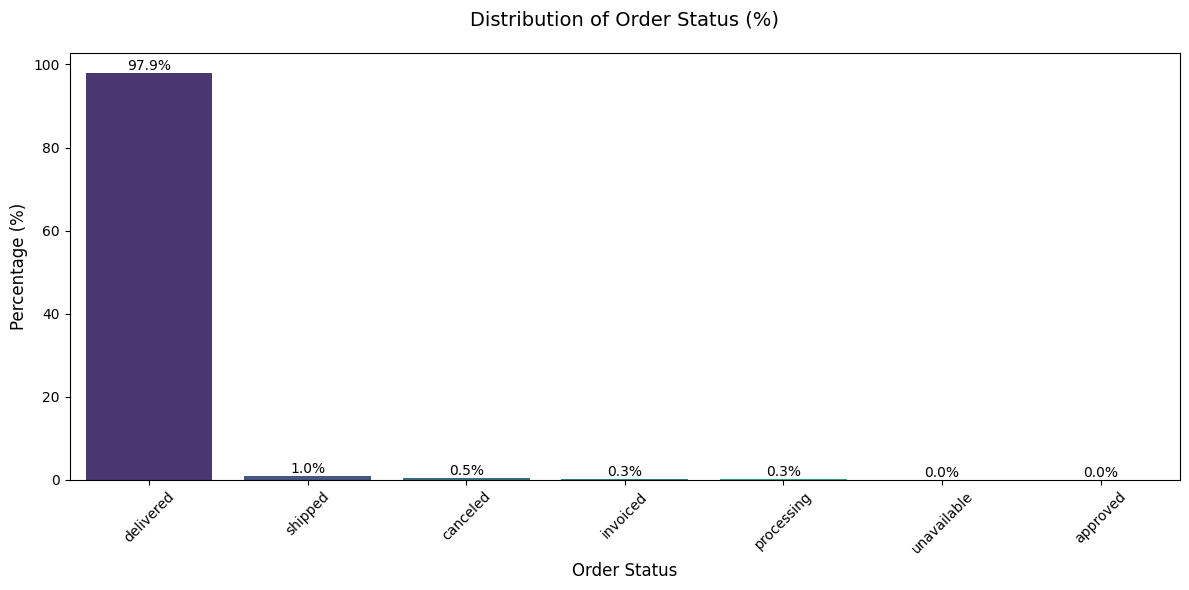


Detailed percentages:
delivered: 97.9%
shipped: 1.0%
canceled: 0.5%
invoiced: 0.3%
processing: 0.3%
unavailable: 0.0%
approved: 0.0%


In [17]:
# Calculate percentages
status_counts = df_sample['order_status'].value_counts()
status_percentages = (status_counts / len(df_sample) * 100).round(2)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=status_percentages.index, y=status_percentages.values, palette='viridis')

# Customize the plot
plt.title('Distribution of Order Status (%)', fontsize=14, pad=20)
plt.xlabel('Order Status', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Add percentage labels on top of each bar
for i, v in enumerate(status_percentages.values):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

# Print exact percentages
print("\nDetailed percentages:")
for status, percentage in status_percentages.items():
    print(f"{status}: {percentage:.1f}%")

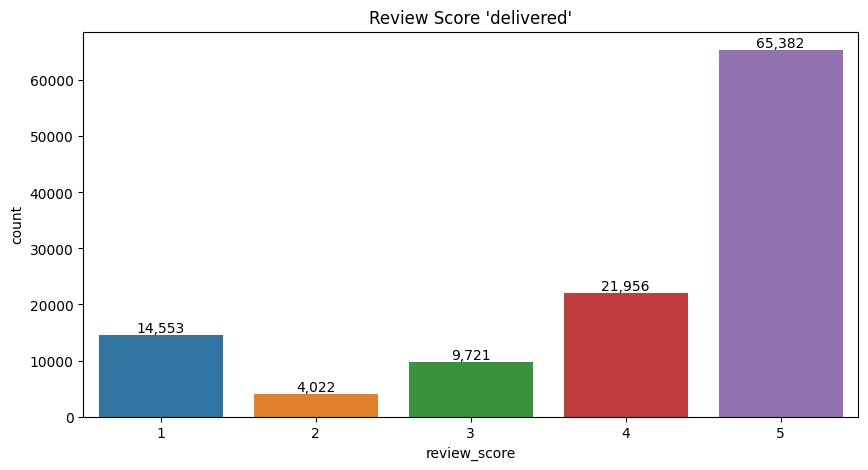

In [16]:
df_score = df_sample.review_score.value_counts()
plt.figure(figsize=(10,5))
chart = sns.barplot(x=df_score.index, y=df_score)
chart.set(title="Review Score 'delivered'")

for i, v in enumerate(df_score.sort_index().values):
    plt.text(i, v, f'{int(v):,}', ha='center', va='bottom')
plt.show()

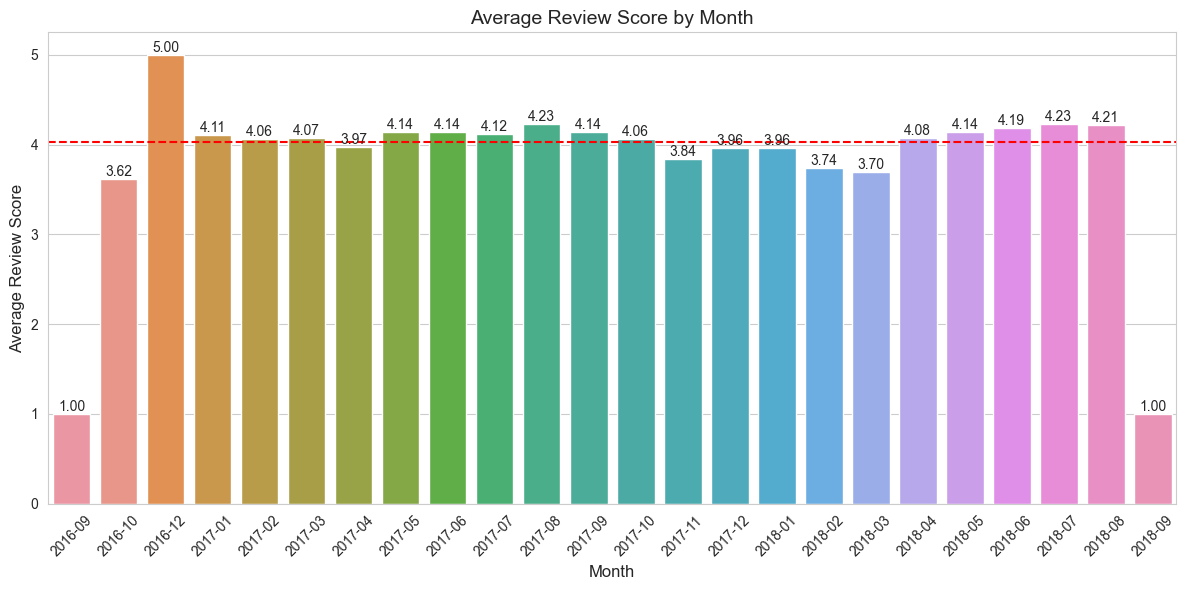

In [17]:
df_monthly_order_score = df_sample.groupby([df_sample['purchase_year_month']]).agg({'review_score':'mean'}).reset_index()
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(x=df_monthly_order_score.purchase_year_month, y=df_monthly_order_score.review_score)

# Customizing the chart
plt.title('Average Review Score by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)
plt.axhline(y=mean_score, color='r', linestyle='--')

# Adding values above the bars
for i, v in enumerate(df_monthly_order_score.review_score):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Adjusting the layout
plt.xticks(rotation=45)
plt.tight_layout()

# Displaying the chart
plt.show()

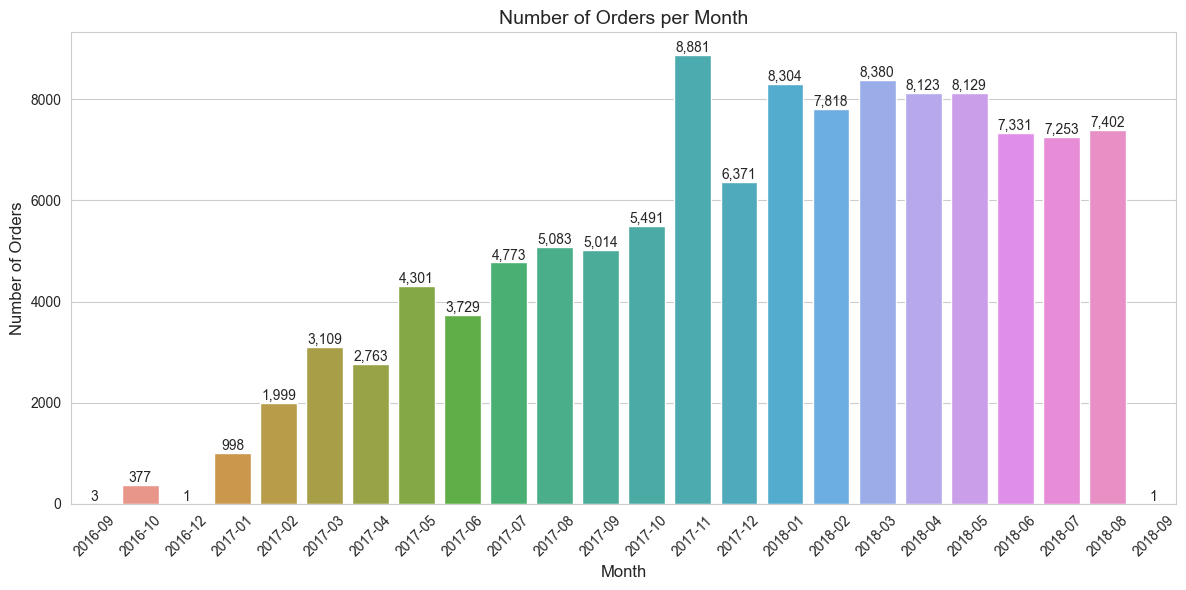

In [18]:
df_monthly_orders = df_sample.groupby([df_sample['purchase_year_month']]).size().reset_index(name='total_orders')

# Setting the style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(x=df_monthly_orders.purchase_year_month, y=df_monthly_orders.total_orders)

# Customizing the chart
plt.title('Number of Orders per Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# Adding values above the bars
for i, v in enumerate(df_monthly_orders.total_orders):
    plt.text(i, v, f'{int(v):,}', ha='center', va='bottom')

# Adjusting the layout
plt.xticks(rotation=45)
plt.tight_layout()

# Displaying the chart
plt.show()

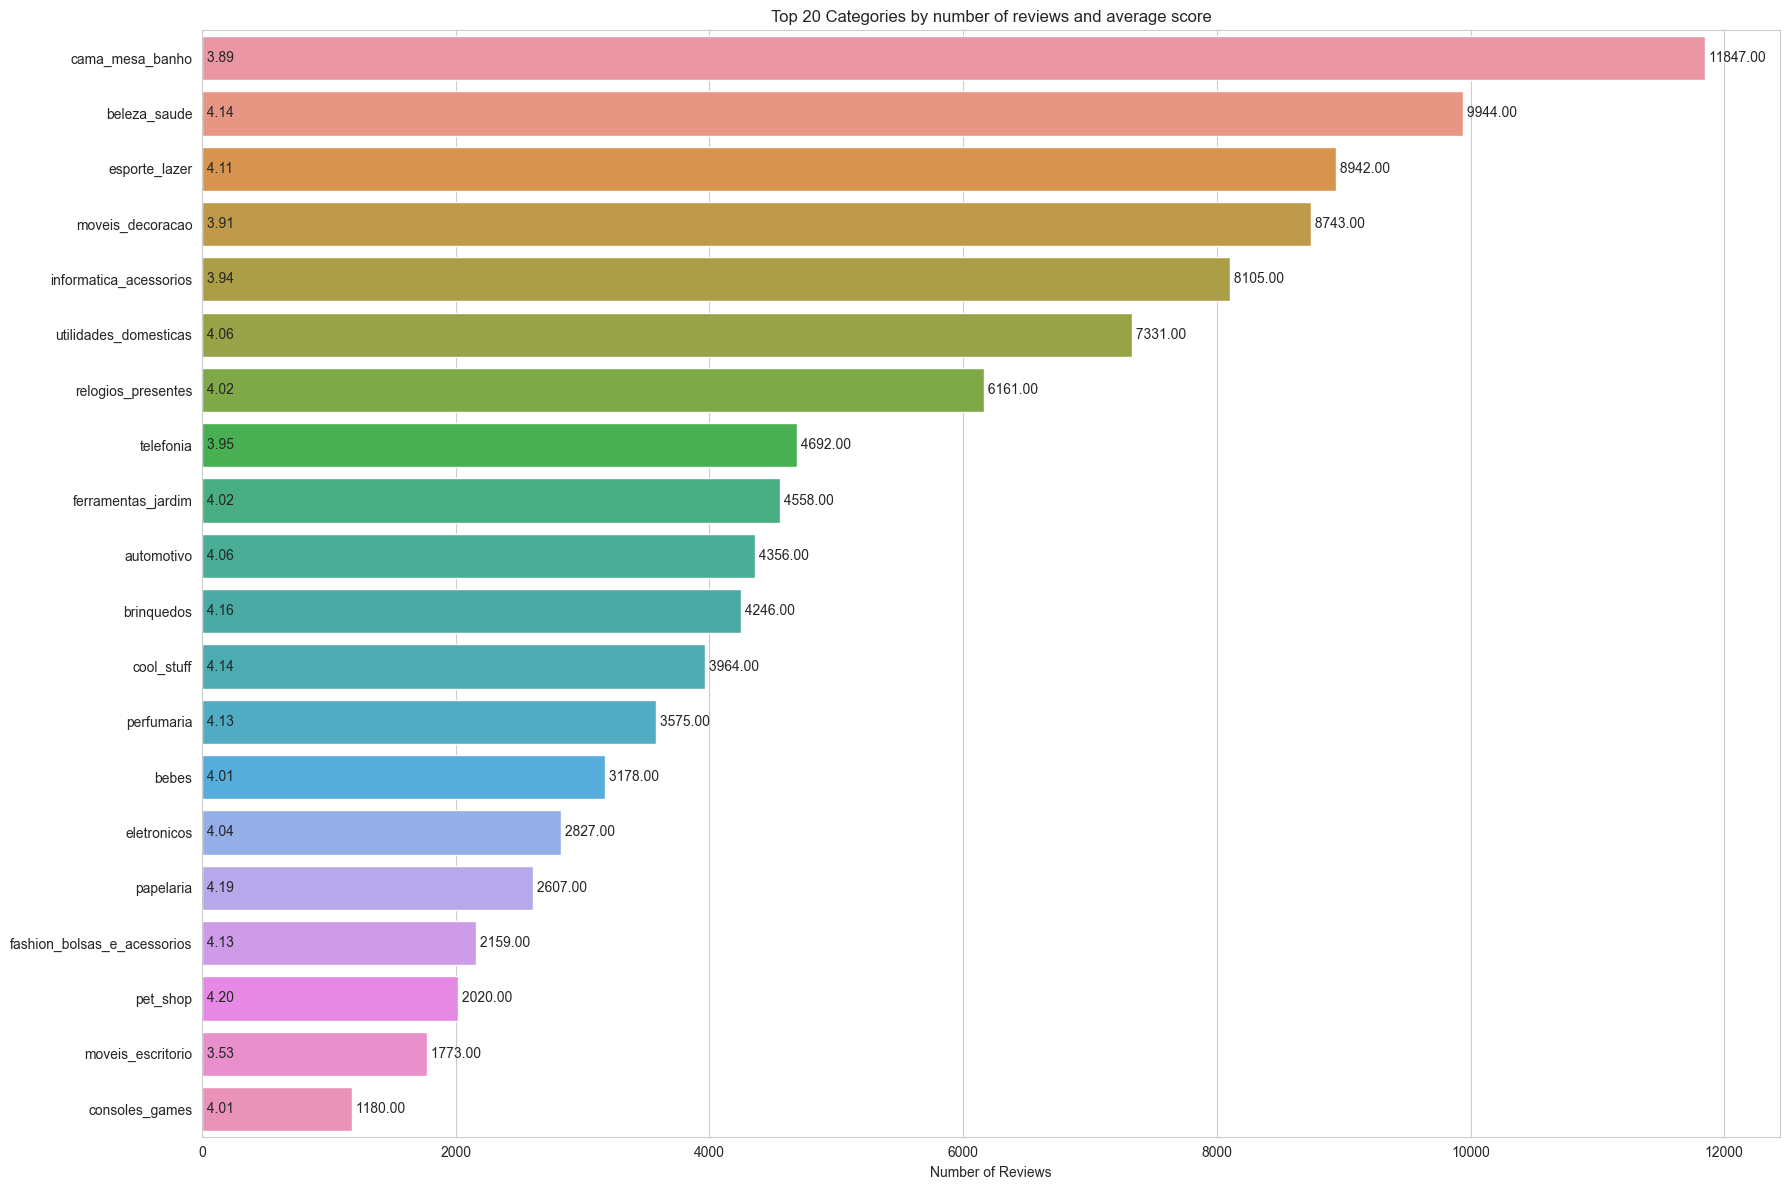

In [19]:
# Group categories by review scores and get mean score
category_scores = df_sample.groupby('product_category_name')['review_score'].agg(['mean', 'count']).round(2)
category_scores = category_scores.sort_values('count', ascending=False)

# Plot top 20 categories by average score
plt.figure(figsize=(18, 12))
sns.barplot(data=category_scores.head(20), x='count', y=category_scores.head(20).index)
plt.title('Top 20 Categories by number of reviews and average score')
plt.xlabel('Number of Reviews')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['count']):
    plt.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')
plt.tight_layout()
plt.show()



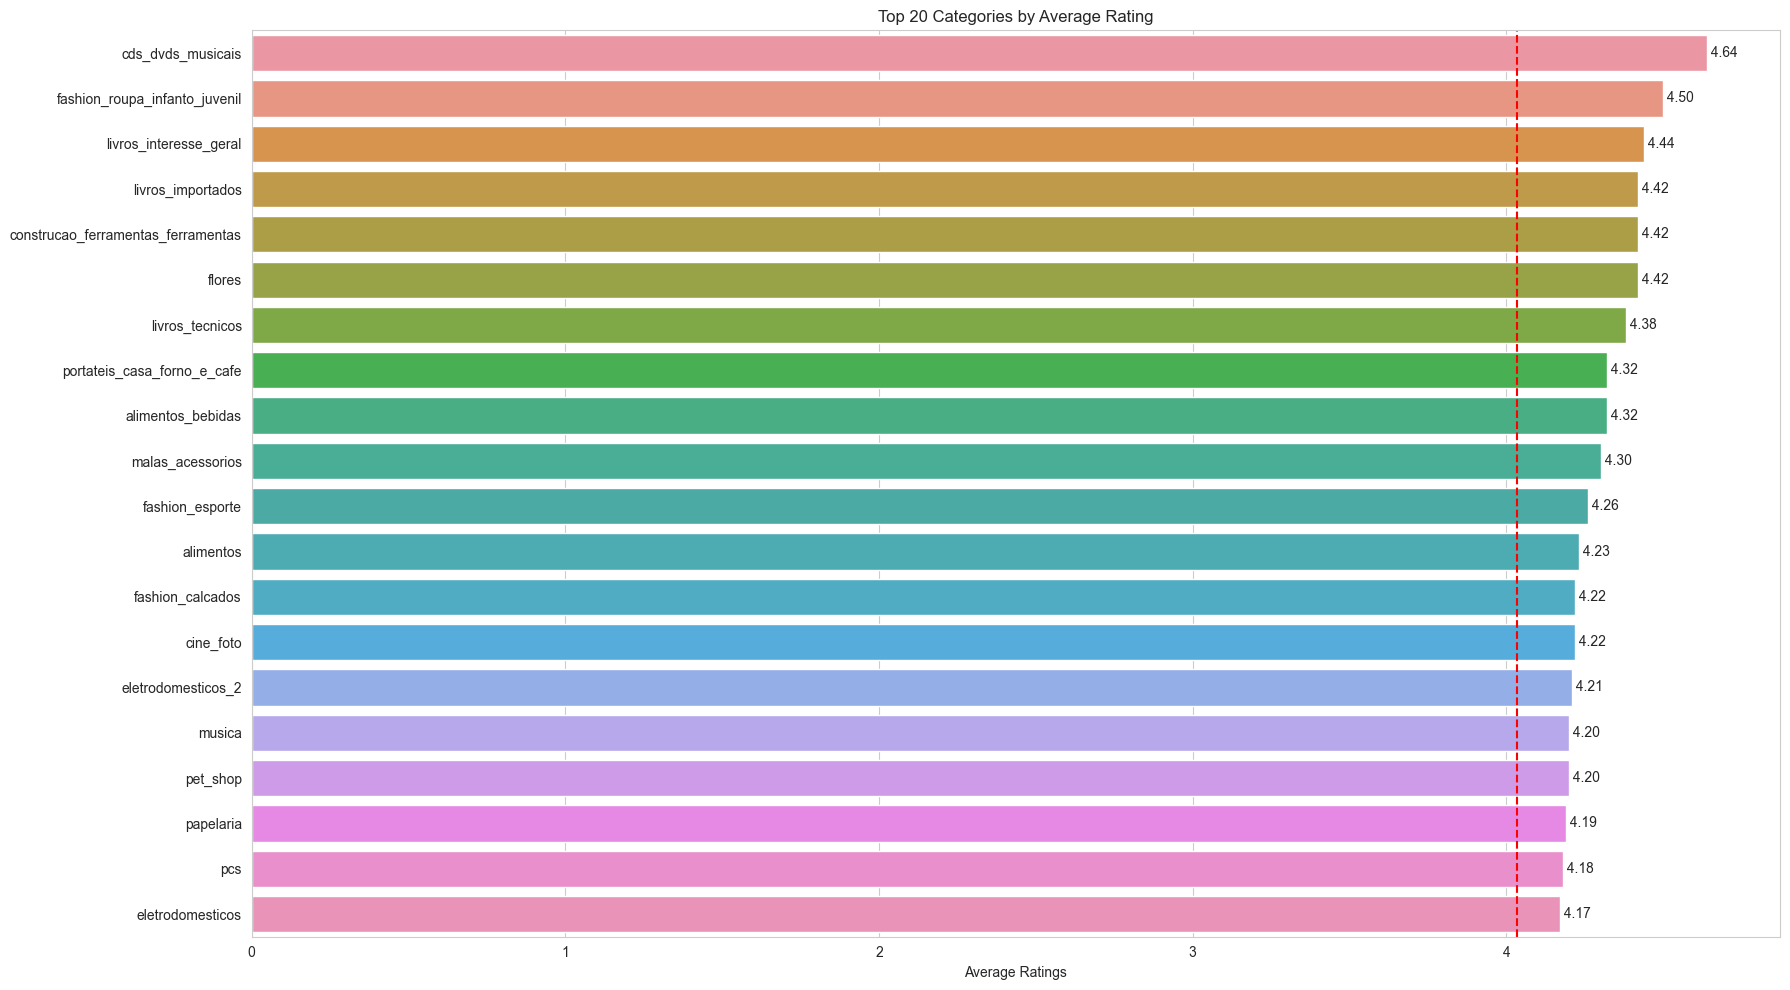

In [20]:
category_scores = category_scores.sort_values('mean', ascending=False)
# Plot top 20 categories by average score
plt.figure(figsize=(18, 10))
sns.barplot(data=category_scores.head(20), x='mean', y=category_scores.head(20).index)
plt.title('Top 20 Categories by Average Rating')
plt.xlabel('Average Ratings')
plt.axvline(x=mean_score, color='r', linestyle='--')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')

plt.tight_layout()
plt.show()

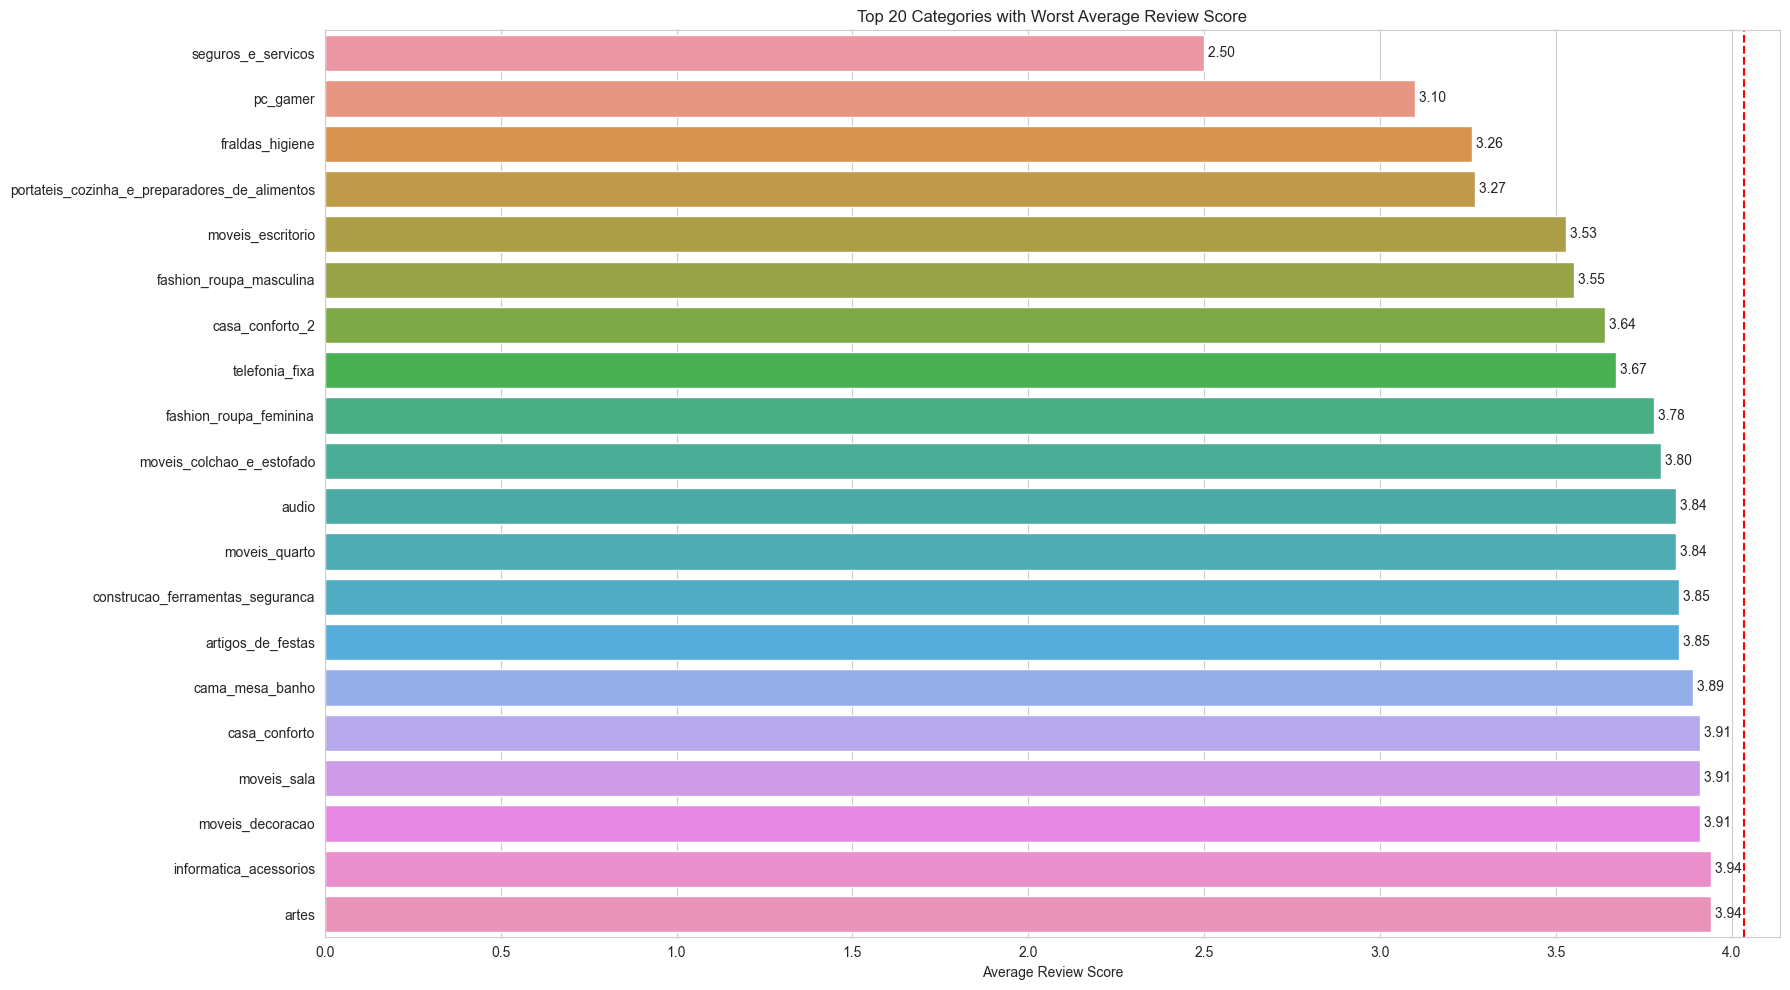

In [21]:
category_scores = category_scores.sort_values('mean', ascending=True)
# Plot top 20 categories
plt.figure(figsize=(18, 10))
sns.barplot(data=category_scores.head(20), x='mean', y=category_scores.head(20).index)
plt.title('Top 20 Categories with Worst Average Review Score')
plt.xlabel('Average Review Score')
plt.axvline(x=mean_score, color='r', linestyle='--')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')

plt.tight_layout()
plt.show()

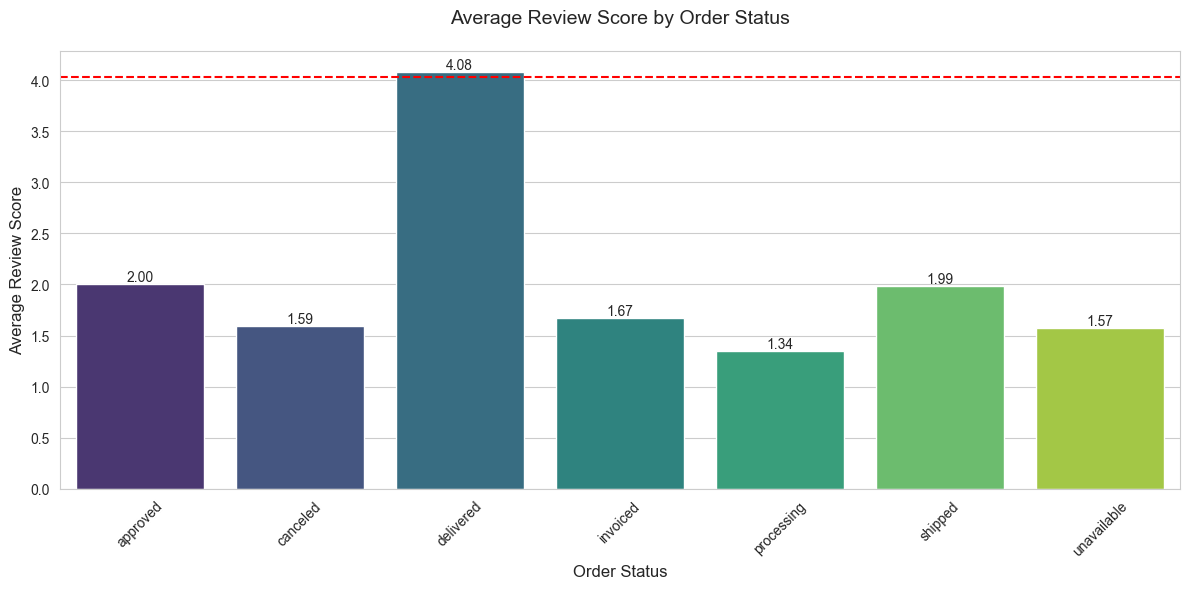

In [22]:
# Calculates the average review_score by order_status
avg_scores = df_sample.groupby('order_status')['review_score'].mean()

# Creates the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=avg_scores.index, y=avg_scores.values, palette='viridis')

# Customizes the plot
plt.title('Average Review Score by Order Status', fontsize=14, pad=20)
plt.xlabel('Order Status', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)
plt.axhline(y=mean_score, color='r', linestyle='--')

# Rotates x-axis labels for better readability
plt.xticks(rotation=45)

# Adds values to the bars
for i, v in enumerate(avg_scores.values):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Adjusts layout
plt.tight_layout()

# Shows the plot
plt.show()

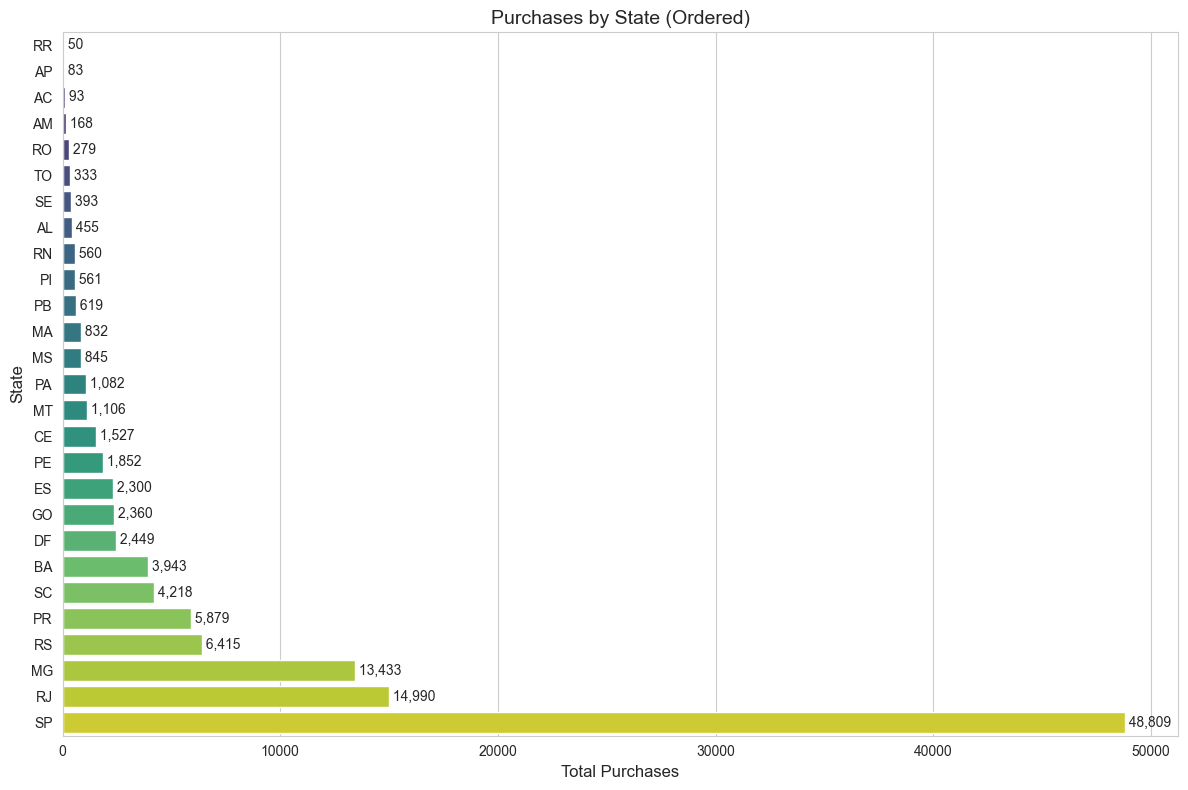

In [23]:
# Create Horizontal Bar Chart
plt.figure(figsize=(12, 8))

# Prepare Ordered Data
df_groupby = df_sample.groupby('customer_state').size().sort_values(ascending=True).reset_index(name='quantity')

# Create the Chart
sns.barplot(data=df_groupby,
            y='customer_state',
            x='quantity',
            palette='viridis')

# Customize the Chart
plt.title('Purchases by State (Ordered)', fontsize=14)
plt.xlabel('Total Purchases', fontsize=12)
plt.ylabel('State', fontsize=12)

# Add Values to Bars
for i, v in enumerate(df_groupby['quantity']):
    plt.text(v, i, f' {int(v):,}', va='center')

plt.tight_layout()
plt.show()


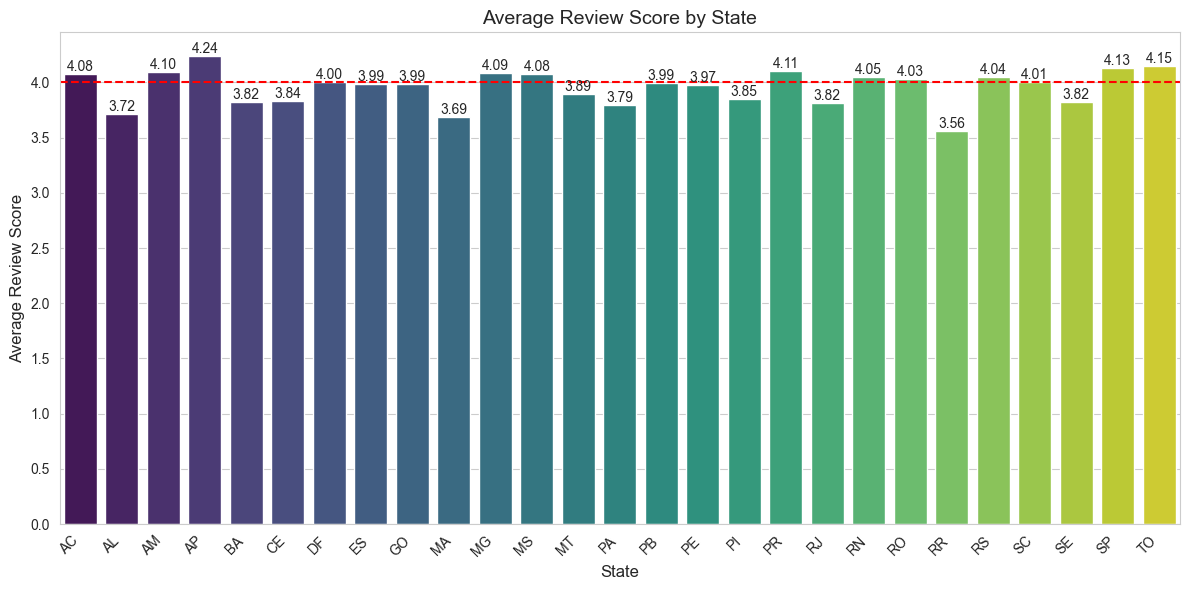

In [24]:
df_state_review = df_sample.groupby('customer_state')['review_score'].mean().reset_index()

# Create Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', 
            y='review_score', 
            data=df_state_review,
            palette='viridis')

# Customize the Chart
plt.title('Average Review Score by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)
plt.axhline(y=4.0, color='r', linestyle='--')

# Rotate X-axis Labels
plt.xticks(rotation=45, ha='right')

# Add Values on Bars
for i, v in enumerate(df_state_review['review_score']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


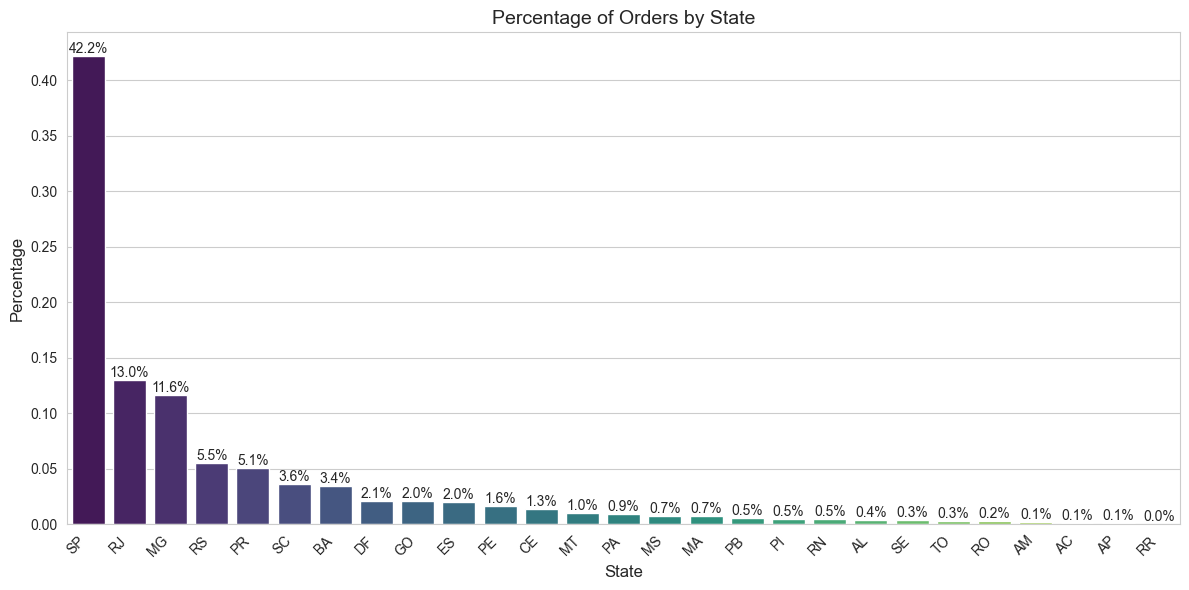

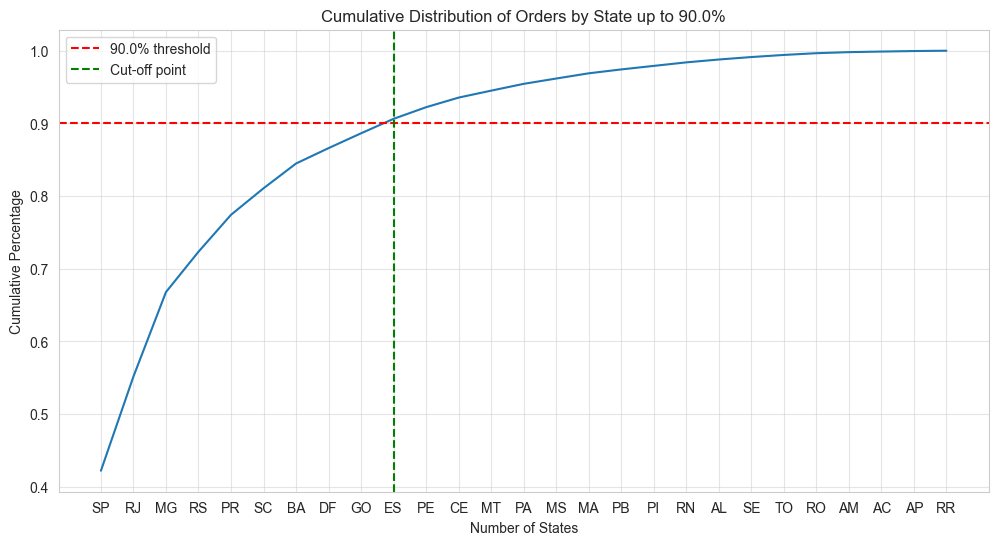

Number of Brazilian states that represent 90.0% of sales: 9
['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'DF', 'GO']


In [25]:
df_sorted = df_groupby.sort_values(by='quantity', ascending=False)
df_sorted['porcentagem_amount'] = df_sorted['quantity'] / df_sorted['quantity'].sum()
df_sorted['cumulative_percentage'] = df_sorted['porcentagem_amount'].cumsum()

df_sorted = df_sorted.reset_index()
# Create bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', 
            y='porcentagem_amount', 
            data=df_sorted,
            palette='viridis')

# Customize the chart
plt.title('Percentage of Orders by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Percentage', fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add values to the bars
for i, v in enumerate(df_sorted['porcentagem_amount']):
    plt.text(i, v, f'{v:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


percentage = 0.9
cities_80_percent = df_sorted[df_sorted['cumulative_percentage'] <= percentage].reset_index()

# Optional: Create visualization
plt.figure(figsize=(12, 6))
plt.plot(df_sorted['customer_state'], df_sorted['cumulative_percentage'])
plt.axhline(y=percentage, color='r', linestyle='--', label=f'{percentage*100}% threshold')
plt.axvline(x=len(cities_80_percent), color='g', linestyle='--', label='Cut-off point')
plt.title(f'Cumulative Distribution of Orders by State up to {percentage*100}%')
plt.xlabel('Number of States')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.grid(True,alpha=0.5)
plt.show()
print(f'Number of Brazilian states that represent {percentage*100}% of sales: {len(cities_80_percent)}')
print(list(cities_80_percent.customer_state))

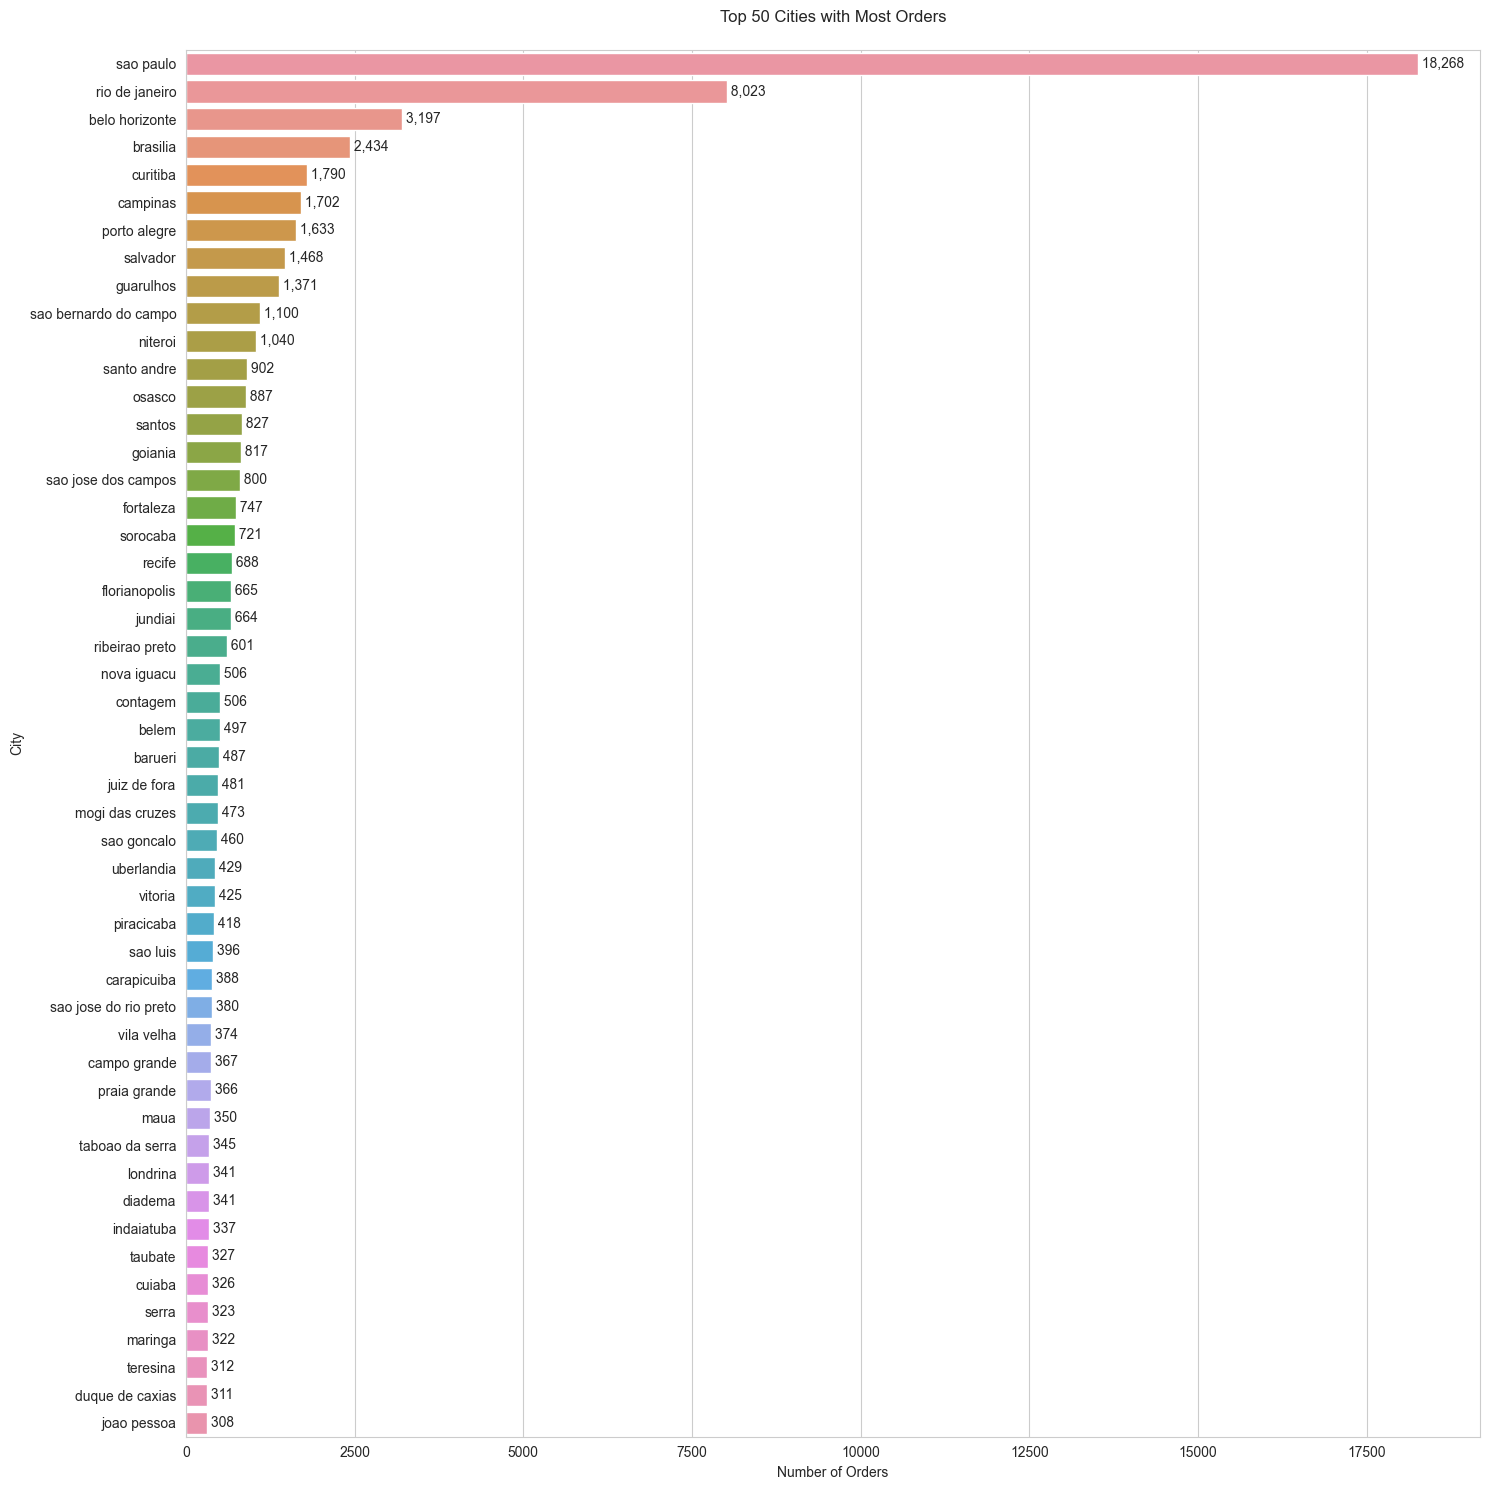

In [26]:
# Get top 50 cities for better visualization
top_cities = df_sample.customer_city.value_counts().head(50)

# Create the plot
plt.figure(figsize=(15, 15))
sns.barplot(x=top_cities.values, y=top_cities.index)

# Customize the plot
plt.title('Top 50 Cities with Most Orders', pad=20)
plt.xlabel('Number of Orders')
plt.ylabel('City')

# Add value labels on bars
for i, v in enumerate(top_cities.values):
    plt.text(v, i, f' {v:,}', va='center')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


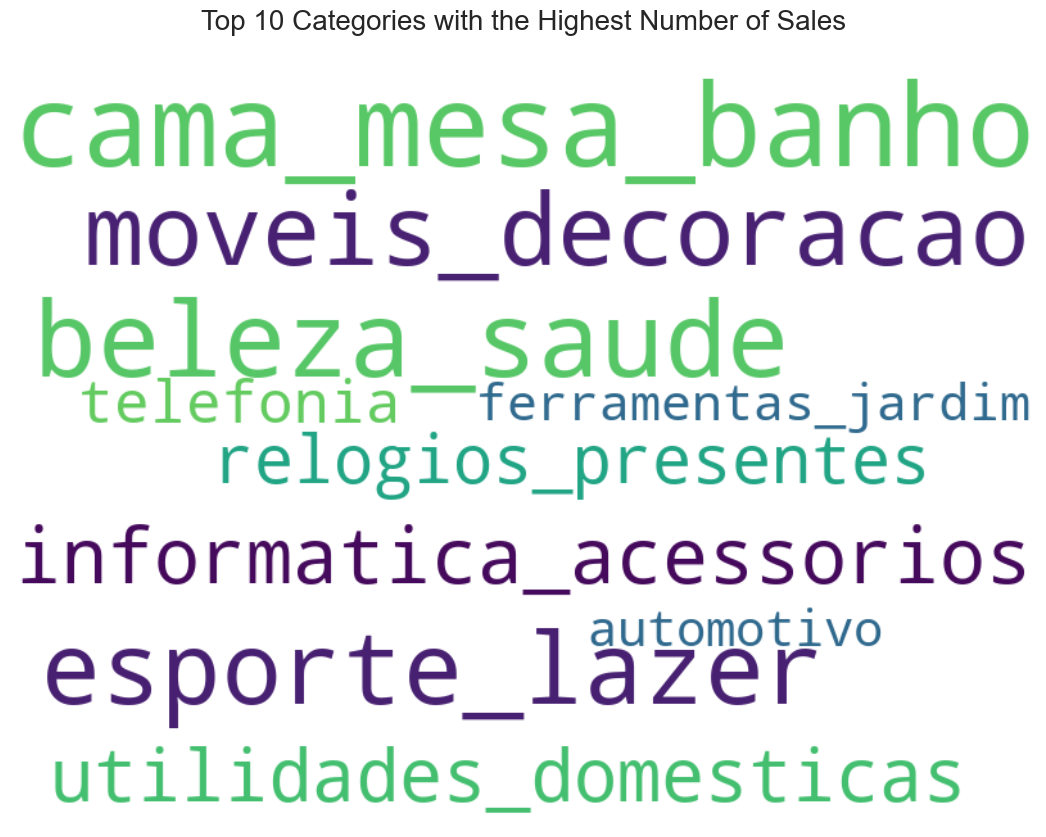

In [27]:
# Create dictionary for wordcloud
word_dict = dict(df_sample.product_category_name.value_counts().head(10))

# Configure and create WordCloud
wordcloud = WordCloud(
    width=800,
    height=600,
    background_color='white',
    colormap='viridis',  # You can try other colormaps like 'plasma', 'magma', 'YlOrRd','viridis'
    min_font_size=10,
    max_font_size=200,
    random_state=42
).generate_from_frequencies(word_dict)

# Create plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Categories with the Highest Number of Sales', 
          fontsize=20, 
          pad=20)

# Show plot
plt.show()

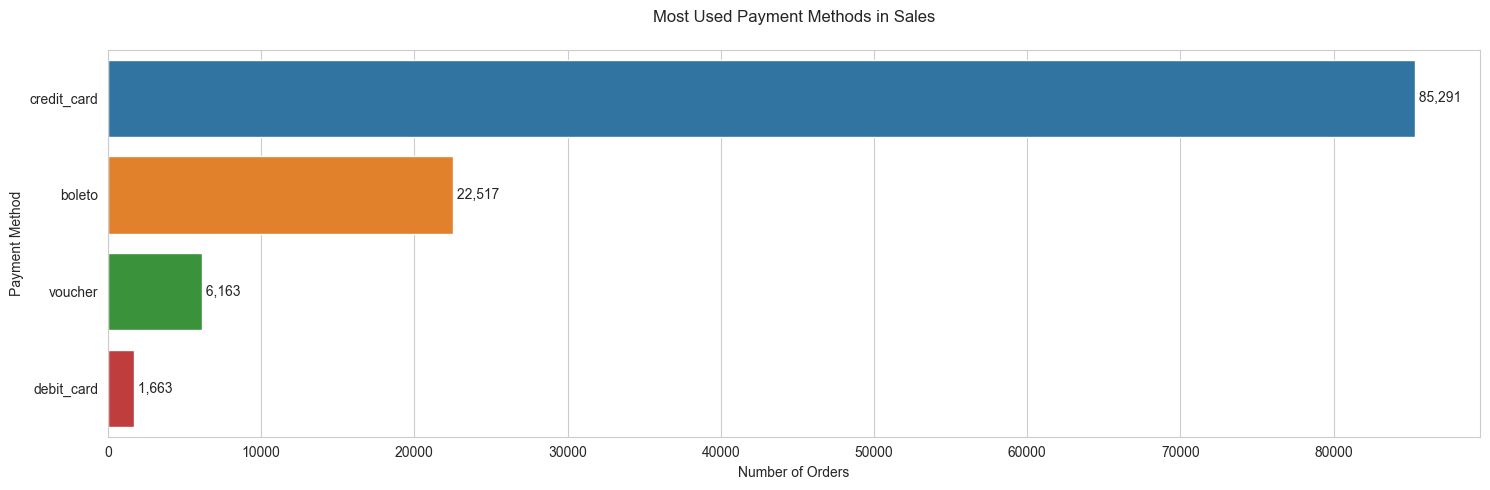

In [28]:
# Get top 50 cities for better visualization
tipo_pagamento = df_sample.payment_type.value_counts()

# Create the plot
plt.figure(figsize=(15, 5))
sns.barplot(x=tipo_pagamento.values, y=tipo_pagamento.index)

# Customize the plot
plt.title('Most Used Payment Methods in Sales', pad=20)
plt.xlabel('Number of Orders')
plt.ylabel('Payment Method')

# Add value labels on bars
for i, v in enumerate(tipo_pagamento.values):
    plt.text(v, i, f' {v:,}', va='center')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

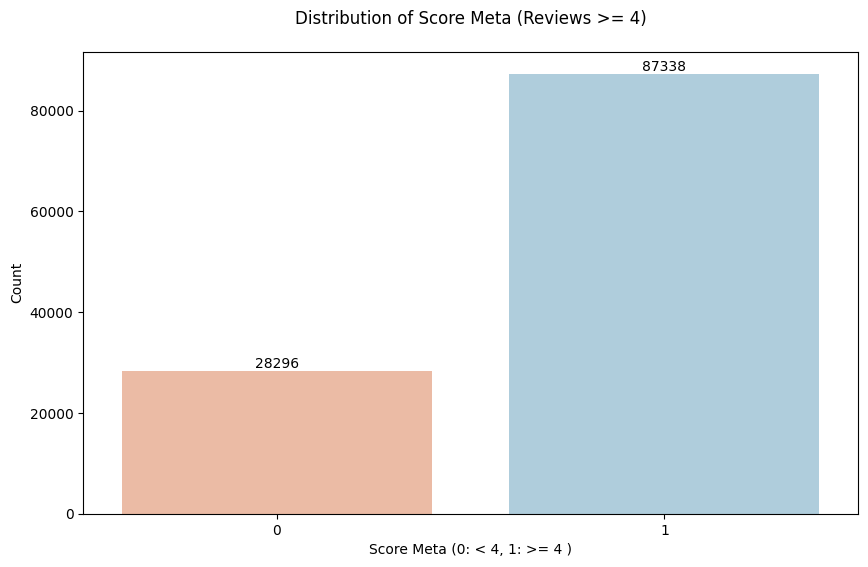

In [18]:
#ETAPA FINAL ANTES DO MODELO

# Create score_meta column
df_sample['score_meta'] = (df_sample.review_score >= 4).astype(int)

# Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sample, x='score_meta', palette='RdBu')

# Add value labels on top of bars
for i in plt.gca().containers:
    plt.gca().bar_label(i)

# Customize the plot
plt.title(f'Distribution of Score Meta (Reviews >= 4)', pad=20)
plt.xlabel(f'Score Meta (0: < 4, 1: >= 4 )')
plt.ylabel('Count')

# Show plot
plt.show()

In [19]:
df_sample = df_sample.drop(columns=['review_score','customer_city','seller_city','purchase_year_month','order_status'])


### Correlation Analysis
This visualization shows the Spearman correlation between numerical variables in our dataset. We use:
- Spearman correlation: Better for non-linear relationships and robust to outliers
- RdBu_r colormap: Red for negative correlations, Blue for positive correlations
- Normalized scale: Values range from -1 (perfect negative correlation) to 1 (perfect positive correlation)

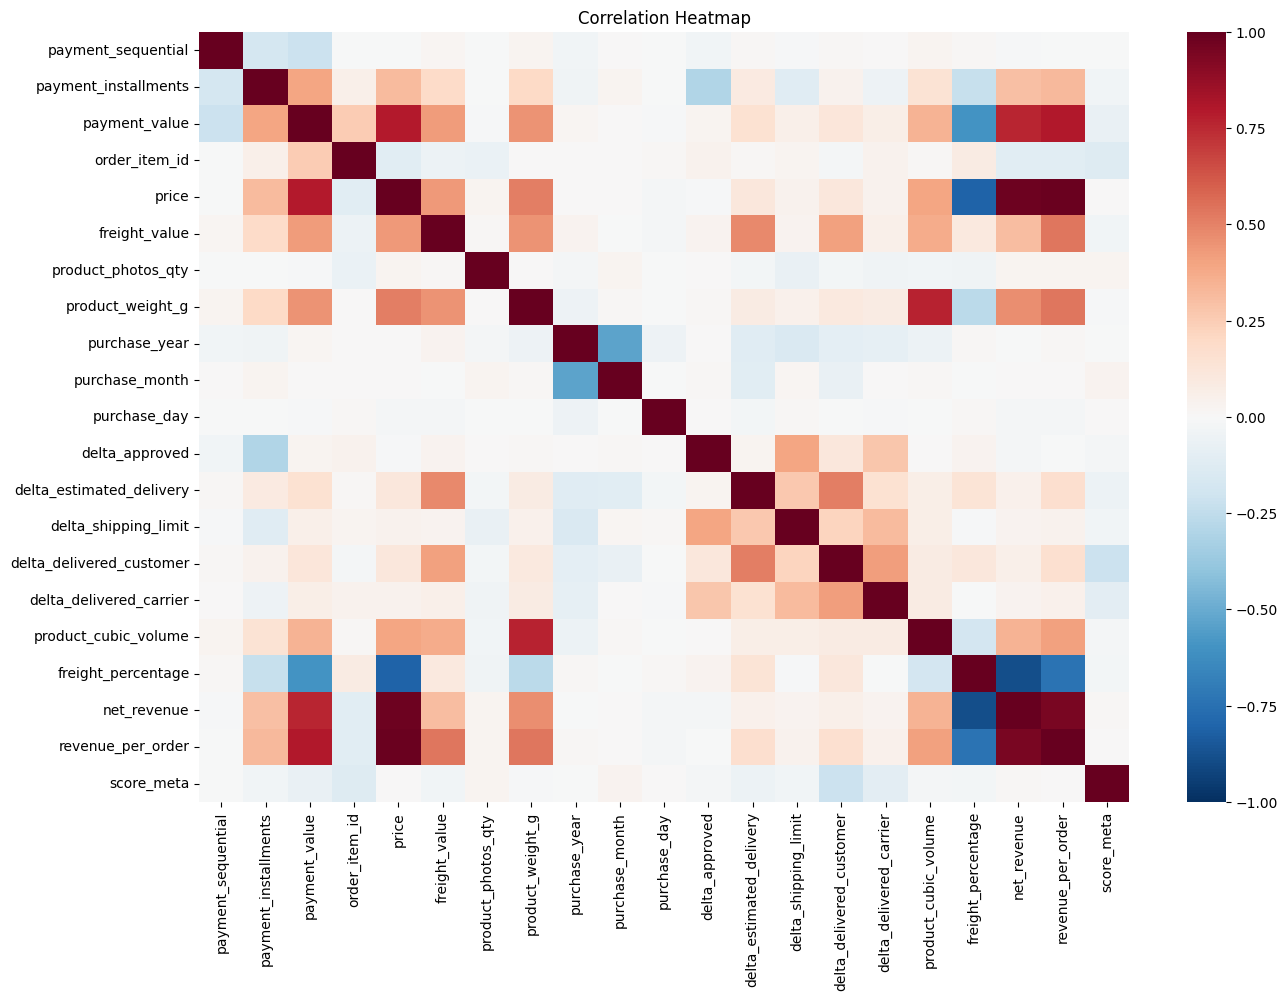

In [20]:
# Calculate Spearman correlation for numerical columns
sample_corr = df_sample.select_dtypes(include=['number']).corr(method='spearman')

# Create correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(sample_corr, cmap='RdBu_r', norm=plt.Normalize(-1,1))
plt.title("Correlation Heatmap")
plt.show()

### Data Preprocessing: One-Hot Encoding

This section handles the conversion of categorical variables into a format suitable for machine learning models through one-hot encoding. The process includes:

1. Converting categorical variables into booleans (dummy) variables
2. Comparing the dimensionality before and after transformation

This step is crucial for:
- Preparing categorical data for ML algorithms
- Maintaining data integrity
- Ensuring proper representation of categorical features

In [21]:
df_dummies = pd.get_dummies(df_sample, drop_first=False)
df_dummies.head(2)

,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_photos_qty,product_weight_g,purchase_year,purchase_month,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,1,1,18.12,1,29.99,8.72,4.0,500.0,2017,10,...,False,False,False,False,False,False,False,False,False,True
1,3,1,2.00,1,29.99,8.72,4.0,500.0,2017,10,...,False,False,False,False,False,False,False,False,False,True


## Data Split into Training and Testing

Data splitting is a crucial step in the machine learning process:

### Parameters Used
- **test_size=0.2**:
    - 20% of the data is separated for testing
    - 80% of the data is kept for training
    - This proportion is common in practice and offers a good balance

- **random_state=42**:
    - Ensures that the split is reproducible
    - Same result every time the code is executed
    - Important for comparing different models

In [22]:
## Divide data into features (X) and target (y)
X = df_dummies.drop(columns=['score_meta'])
y = df_dummies['score_meta']

# Divide data into training and test sets
# X: features (independent variables)
# y: target (dependent/target variable)
# test_size=0.2: 20% of data for testing, 80% for training
# random_state=42: ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((92507, 148), (23127, 148), (92507,), (23127,))

### Outlier Treatment Transformer

This code implements a custom transformer for outlier treatment using the Interquartile Range (IQR) method.

### How it Works

1. **Initialization**:
   - Creates variables to store Q1 (first quartile), Q3 (third quartile), and IQR (interquartile range).

2. **Fit Method**:
   - Calculates Q1 (25th percentile).
   - Calculates Q3 (75th percentile).
   - Calculates IQR (Q3 - Q1).

3. **Transform Method**:
   - Calculates outlier boundaries using the formula:
     - Lower bound = Q1 - 1.5 * IQR
     - Upper bound = Q3 + 1.5 * IQR
   - Applies the bounds to the data using clip().

### Usage

This transformer can be used in scikit-learn pipelines to automatically handle outliers in the data during preprocessing.

### Advantages

- Robust and non-parametric method.
- Preserves the data distribution within acceptable limits.
- Compatible with scikit-learn.


In [23]:
def treat_outliers_iqr(df, factor=1.5):
    """
    Treats outliers in numerical variables using the IQR (Interquartile Range) method.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        factor (float): IQR multiplier factor (default = 1.5)
    
    Returns:
        pd.DataFrame: DataFrame with treated outliers
    """
    # Create a copy of DataFrame to avoid modifying the original
    df_treated = df.copy()
    
    # Select numerical columns
    numeric_columns = df.select_dtypes(include=['number']).columns
  
    for column in numeric_columns:
        # Calculate Q1, Q3 and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define boundaries
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
                
        # Apply treatment (clipping)
        df_treated[column] = df_treated[column].clip(
            lower=lower_bound,
            upper=upper_bound
        )
    
    return df_treated

In [24]:
columns_number = X_train.select_dtypes(include=['number']).columns
columns_number

Index(['payment_sequential', 'payment_installments', 'payment_value',
       'order_item_id', 'price', 'freight_value', 'product_photos_qty',
       'product_weight_g', 'purchase_year', 'purchase_month', 'purchase_day',
       'delta_approved', 'delta_estimated_delivery', 'delta_shipping_limit',
       'delta_delivered_customer', 'delta_delivered_carrier',
       'product_cubic_volume', 'freight_percentage', 'net_revenue',
       'revenue_per_order'],
      dtype='object')

In [25]:
X_train[columns_number] = treat_outliers_iqr(X_train[columns_number])

## Data Standardization Process

### Overview
This code segment implements feature standardization, a crucial preprocessing step in machine learning, using scikit-learn's StandardScaler.

### Technical Details

#### StandardScaler Implementation
- Transforms features to have:
  - Mean = 0
  - Standard deviation = 1
- Helps prevent features with larger scales from dominating the model
- Essential for algorithms sensitive to feature scaling (e.g., neural networks, SVM)

#### Process Flow
1. **Scaler Initialization**
   - Creates a new StandardScaler instance
   - Prepares for feature transformation

2. **Training Data Processing**
   - Fits scaler to training data
   - Learns mean and standard deviation
   - Transforms training data
   - Preserves DataFrame structure

3. **Test Data Processing**
   - Uses parameters learned from training data
   - Ensures consistent transformation
   - Prevents data leakage

### Benefits
- Improves model performance
- Ensures fair feature comparison
- Accelerates model convergence
- Maintains data integrity through DataFrame structure

### Best Practices
- Always fit scaler on training data only
- Apply same transformation to test data
- Preserve column names and index for traceability

In [26]:
# Initialize the StandardScaler object for feature scaling
scaler = StandardScaler()

# Transform training data: standardize features by removing the mean and scaling to unit variance
X_train_standardized = pd.DataFrame(
    scaler.fit_transform(X_train),  # Fit to training data and transform it
    columns=X_train.columns,        # Maintain original column names
    index=X_train.index            # Preserve index for traceability
)

# Salvar o scaler para uso posterior
with open('output/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

#salvar as colunas
with open('output/columns.pkl', 'wb') as file:
    pickle.dump(X_train.columns, file)

    
# Transform test data: using parameters learned from training data
X_test_standardized = pd.DataFrame(
    scaler.transform(X_test),      # Transform test data using training data parameters
    columns=X_test.columns,        # Maintain original column names
    index=X_test.index            # Preserve index for traceability
)

In [27]:
X_train_standardized.head(2)

,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_photos_qty,product_weight_g,purchase_year,purchase_month,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
43127,0.0,-0.336130,-0.241823,0.0,0.049118,-0.617951,-0.756017,0.657837,0.911914,-1.562354,...,-0.062591,-0.010398,-0.289182,-0.211671,-0.022305,-0.01139,-0.140029,-0.19429,-0.008699,0.634725
23604,0.0,-0.740126,-0.776954,0.0,-0.637768,-1.226695,-0.756017,-0.896564,-1.068331,-0.941169,...,-0.062591,-0.010398,-0.289182,-0.211671,-0.022305,-0.01139,-0.140029,-0.19429,-0.008699,0.634725


## PCA (Principal Component Analysis) Implementation

### Purpose
This code performs Principal Component Analysis to evaluate and potentially reduce the dimensionality of the dataset while preserving important information.

### Process Steps
1. **Initial PCA Setup**
   - Fits PCA to standardized training data
   - No predefined number of components

2. **Variance Analysis**
   - Calculates individual variance contribution per component
   - Computes cumulative variance

3. **Visualization**
   - Two subplots showing:
     - Individual variance contribution
     - Cumulative variance with 95% threshold

4. **Component Analysis**
   - Detailed breakdown of first 10 components
   - Shows individual and cumulative contribution

5. **Optimal Components**
   - Determines number of components needed for 95% variance
   - Evaluates potential dimensionality reduction

6. **Feasibility Check**
   - Assesses if PCA is worthwhile
   - Warning if reduction is minimal (>80% of original features needed)

### Key Metrics
- Target variance threshold: 95%
- Feasibility threshold: 80% of original dimensions

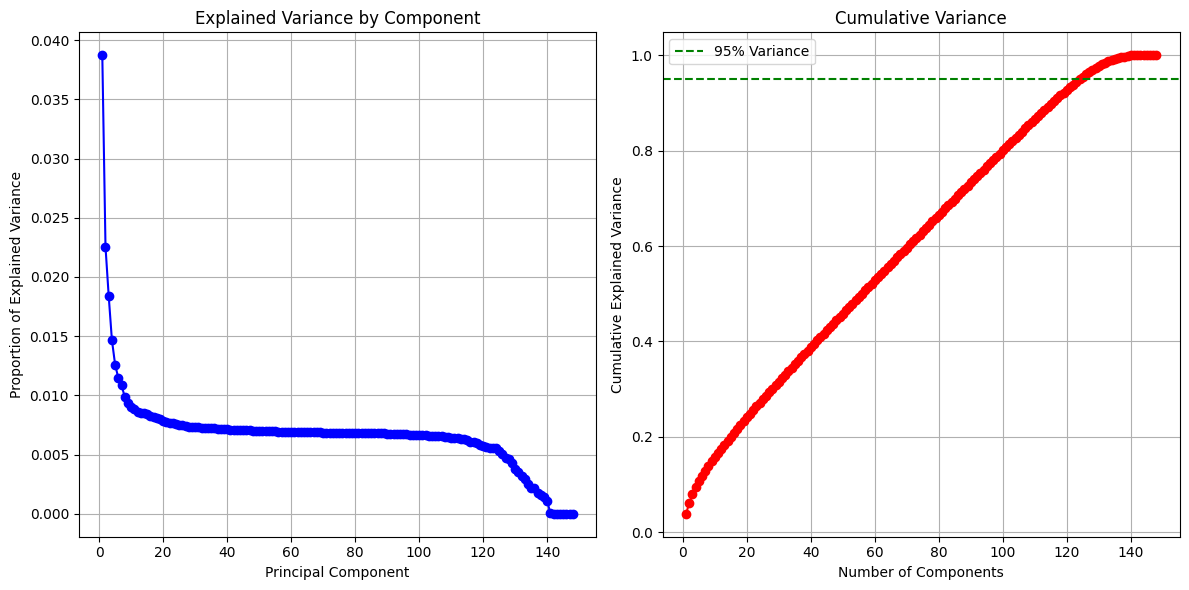


Variance Analysis:
PC1: 0.0387 (0.0387 cumulative)
PC2: 0.0225 (0.0613 cumulative)
PC3: 0.0184 (0.0797 cumulative)
PC4: 0.0147 (0.0943 cumulative)
PC5: 0.0126 (0.1070 cumulative)
PC6: 0.0115 (0.1184 cumulative)
PC7: 0.0109 (0.1293 cumulative)
PC8: 0.0099 (0.1392 cumulative)
PC9: 0.0094 (0.1486 cumulative)
PC10: 0.0090 (0.1576 cumulative)

Components needed for 95% variance: 125
Dimensionality reduction: 148 -> 125

- We need 125 components to explain 95% of variance
- This represents 84.5% of original features
Recommendation: Consider not using PCA in this case


In [28]:
# 1. Initial analysis of explained variance
pca = PCA()
pca.fit(X_train_standardized)

# 2. Detailed variance analysis
individual_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(individual_variance)

# 3. Detailed visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(individual_variance) + 1), individual_variance, 'bo-')
plt.title('Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
plt.title('Cumulative Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 4. Numerical analysis
print("\nVariance Analysis:")
for i, var in enumerate(individual_variance[:10], 1):
    print(f"PC{i}: {var:.4f} ({cumulative_variance[i-1]:.4f} cumulative)")

# 5. Determine ideal number of components
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}")
print(f"Dimensionality reduction: {X_train_standardized.shape[1]} -> {n_components_95}")

# 6. Verify if PCA is actually beneficial
if n_components_95 >= X_train_standardized.shape[1] * 0.8:
    print("\nWARNING: PCA might not be beneficial in this case because:")
    print(f"- We need {n_components_95} components to explain 95% of variance")
    print(f"- This represents {n_components_95/X_train_standardized.shape[1]*100:.1f}% of original features")
    print("Recommendation: Consider not using PCA in this case")

## Machine Learning Model Configuration

This code configures four different machine learning models for comparison:

### Common Features
- All models use the same random seed (42) for reproducibility
- Parallelization enabled in all (`n_jobs=-1` or `thread_count=-1`)
- Silent mode enabled for clean execution
- Specific hyperparameter ranges for each model

### Implemented Models

1. **Random Forest**
    - Ensemble of decision trees
    - 100-300 trees
    - Maximum depth: 10-40

2. **XGBoost**
    - Optimized gradient boosting
    - Uses logloss as metric
    - Maximum depth: 3-40

3. **LightGBM**
    - Efficient implementation by Microsoft
    - Optimized for large datasets
    - Maximum depth: 6-40

4. **CatBoost**
    - Specialized in categorical features
    - Smaller depth (4-12) due to sensitivity
    - Better automatic handling of categories

### Structure
- Each model is configured in a dictionary
- Parameters separated into 'model' (instance) and 'params' (for optimization)
- Prefix 'model__' required for use in Pipeline


In [29]:
# Set a random seed for reproducibility
seed = 42

# Dictionary with machine learning model configurations
models = {
    # Random Forest: Model based on multiple decision trees
    "RandomForest": {
        'model': RandomForestClassifier(
            random_state=seed,  # Ensures reproducibility
            n_jobs=-1,         # Uses all available CPUs
            verbose=0          # Silent mode
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Number of trees
            'model__max_depth': Integer(10, 40)        # Maximum depth
        }
    },
    
    # XGBoost: Optimized implementation of Gradient Boosting
    "XGBoost": {
        'model': XGBClassifier(
            use_label_encoder=False,  # Disables legacy label encoder
            eval_metric="logloss",    # Evaluation metric
            random_state=seed,        # Ensures reproducibility
            n_jobs=-1,               # Parallelization
            verbose=0                # Silent mode
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Number of boosting rounds
            'model__max_depth': Integer(3, 40)         # Maximum depth
        }
    },
    
    # LightGBM: Efficient Gradient Boosting implementation by Microsoft
    "LightGBM": {
        'model': LGBMClassifier(
            random_state=seed,  # Ensures reproducibility
            verbose=-1,        # Silent mode
            n_jobs=-1         # Parallelization
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Number of boosting rounds
            'model__max_depth': Integer(6, 40)         # Maximum depth
        }
    },
    
    # CatBoost: Specialized in categorical variables
    "CatBoost": {
        'model': CatBoostClassifier(
            verbose=0,          # Silent mode
            random_state=seed,  # Ensures reproducibility
            thread_count=-1     # Uses all threads
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Number of trees
            'model__depth': Integer(4, 12)             # Depth (smaller range due to sensitivity)
        }
    }
}

## Model Training and Evaluation Pipeline

### Overview
This code implements an automated machine learning pipeline that trains and evaluates multiple models using Bayesian hyperparameter optimization. The main goal is to find the best model for predicting customer satisfaction in the Olist e-commerce dataset.

### Pipeline Components

1. **Model Training Loop**
   - Iterates through predefined models in the `models` dictionary
   - Each model is trained using a scikit-learn Pipeline
   - Uses Bayesian optimization for hyperparameter tuning

2. **Hyperparameter Optimization**
   - Implements `BayesSearchCV` for smart parameter search
   - Parameters:
     - 3-fold cross-validation
     - 32 iterations for optimization
     - Accuracy as scoring metric
     - Parallel processing (except for CatBoost)

3. **Model Evaluation**
   - Metrics calculated for each model:
     - Accuracy score
     - Confusion matrix
     - ROC curve and AUC score
   - Results stored for comparison

4. **Model Persistence**
   - Saves trained models to `output/{model_name}_model.pkl`
   - Exports results to `output/model_results.csv`

### Key Features
- Automated training of multiple models
- Intelligent hyperparameter optimization
- Comprehensive model evaluation
- Model persistence for future use
- Comparative analysis of model performance

### Output
- Trained model files
- CSV file with comparative results
- Sorted performance metrics for all models

In [ ]:
# List to store the results of each model
results = []

# Iterate over each model defined in the 'models' dictionary
for name, model_info in models.items():
    print(f'Training {name} ......')   
    # Define the processing and modeling pipeline
    pipeline = Pipeline([
        ('model', model_info['model'])            # ML model
    ])

    # Configure Bayesian hyperparameter search
    bayes_search = BayesSearchCV(
        pipeline,                                 # Pipeline to be optimized
        model_info['params'],                     # Parameter space
        cv=3,                                     # Cross-validation with 3 folds
        n_iter=32,                                # Number of iterations
        scoring='accuracy',                       # Evaluation metric
        n_jobs=-1 if name != "CatBoost" else 1,   # Parallelization (except CatBoost)
        random_state=seed                         # Random seed for reproducibility
    )
    
    # Train the model with hyperparameter search
    bayes_search.fit(X_train_standardized, y_train)

    # Make predictions and calculate accuracy
    y_pred = bayes_search.predict(X_test_standardized)
    accuracy = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)

    y_prob = bayes_search.predict_proba(X_test_standardized)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Store the model results
    results.append({
        "Model": name, 
        "Depth": bayes_search.best_params_['model__depth'] if name == "CatBoost" else bayes_search.best_params_['model__max_depth'],
        "N Estimators": bayes_search.best_params_['model__n_estimators'],
        "Accuracy": accuracy,
        "Confusion Matrix": cm,
        "ROC Curve": (fpr, tpr),
        "ROC AUC": roc_auc
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Sort models by accuracy (best first)
df_results.sort_values(by='Accuracy', ascending=False)



Training RandomForest ......
Training XGBoost ......
Training LightGBM ......
Training CatBoost ......


,Model,Depth,N Estimators,Accuracy,Confusion Matrix,ROC Curve,ROC AUC
1,XGBoost,28,102,0.846327,"[[2840, 2883], [671, 16733]]","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.802711
3,CatBoost,12,300,0.841181,"[[2629, 3094], [579, 16825]]","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.785276
0,RandomForest,39,240,0.840879,"[[2376, 3347], [333, 17071]]","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.818983
2,LightGBM,35,300,0.814805,"[[1942, 3781], [502, 16902]]","([0.0, 0.0, 0.0, 0.0, 0.00017473353136466887, ...",0.759254


In [30]:
rf_model = RandomForestClassifier(
    random_state=seed,  # Ensures reproducibility
    n_jobs=-1,         # Uses all available CPUs
    verbose=0,          # Silent mode
    n_estimators=240,  # Number of trees
    max_depth=39       # Maximum depth

)
rf_model.fit(X_train_standardized, y_train)

# Save Model
with open(f'output/RandomForestClassifier_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)


## Model Performance Analysis


### Comparative Analysis of Models

The analysis compares multiple models using both Accuracy and ROC-AUC metrics, providing a comprehensive view of their performance in predicting customer satisfaction.

#### Detailed Model Performance:

1. **Random Forest**
   - Accuracy: 0.8409 (84.09%)
   - ROC-AUC: 0.8190 (81.90%)
   - Second in accuracy
   - Highest ROC-AUC score
   - Best balance between accuracy and class discrimination
   - Recommended for balanced performance requirements


2. **XGBoost**
   - Accuracy: 0.8463 (84.63%)
   - ROC-AUC: 0.8027 (80.27%)
   - Highest accuracy among all models
   - Lower ROC-AUC suggests some challenges with class separation
   - Best for scenarios prioritizing overall accuracy



### Key Insights:
- All models achieve >80% accuracy, indicating strong predictive power
- Random Forest shows best ROC-AUC, suggesting superior ability to distinguish between classes
- Small accuracy spread (3.15%) between best and worst models indicates consistent performance
- XGBoost-Random Forest trade-off: higher accuracy vs better class separation

### Recommendations:
1. **For Maximum Accuracy:**
   - Use XGBoost (84.63% accuracy)
   - Best for situations where overall correct predictions are priority

2. **For Best Class Separation:**
   - Choose Random Forest (81.90% ROC-AUC)
   - Optimal for cases requiring reliable class probability estimates

3. **For Production Deployment:**
   - Consider Random Forest as primary model
   - Offers best balance of accuracy and class discrimination
   - More robust performance across different scenarios

### Business Impact:
- High accuracy across models ensures reliable customer satisfaction predictions
- Strong ROC-AUC scores indicate good discrimination between satisfied/dissatisfied customers
- Models can effectively support proactive customer service interventions

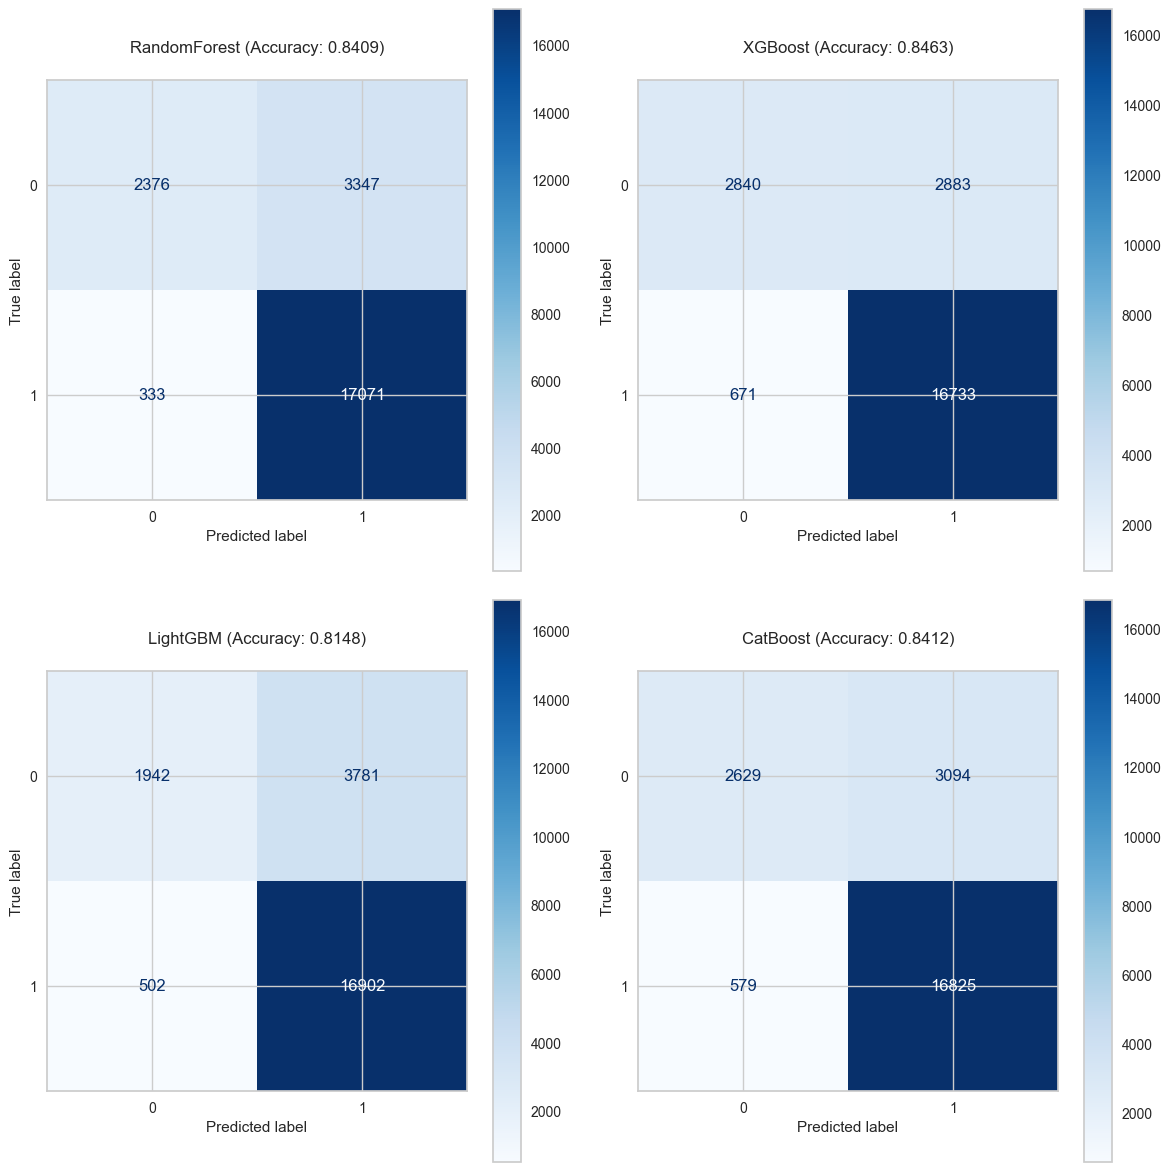

In [181]:
# Create a 2x2 grid of subplots for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()  # Flatten the 2x2 array for easier iteration

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Plot confusion matrix for each model
for idx, (index, row) in enumerate(df_results.iterrows()):
    # Create and plot confusion matrix
    ConfusionMatrixDisplay(row['Confusion Matrix']).plot(
        ax=axes[idx],
        cmap='Blues'  # Use Blues colormap for better visibility
    )
    # Add title with model name and accuracy
    axes[idx].set_title(
        f"{row['Model']} (Accuracy: {row['Accuracy']:.4f})",
        pad=20
    )

# Remove empty subplots
for i in range(len(df_results), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

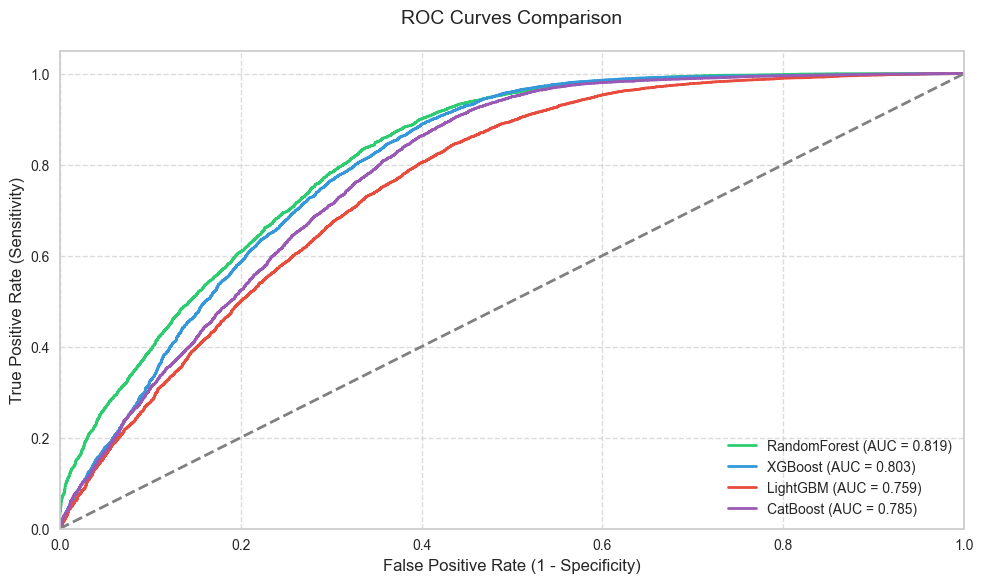

In [182]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 6))

# Colors for each model
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

# Plot ROC curve for each model
for idx, row in df_results.iterrows():
    fpr, tpr = row['ROC Curve']
    roc_auc = row['ROC AUC']
    
    plt.plot(
        fpr, 
        tpr, 
        color=colors[idx],
        lw=2, 
        label=f'{row["Model"]} (AUC = {roc_auc:.3f})'
    )

# Plot reference diagonal line
plt.plot(
    [0, 1], 
    [0, 1], 
    color='gray',
    lw=2, 
    linestyle='--'
)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, pad=20)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Configure legend
plt.legend(loc='lower right', fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

## Feature Importance Analysis Function

### Overview
This function provides a comprehensive analysis of feature importance in machine learning models, helping identify the most influential features and their cumulative impact on the model's predictions.

### Function Components

1. **Input Parameters**
   - `feature_importance_df`: DataFrame containing feature names and their importance scores
   - `n_top_features`: Number of top features to display (default: 10)
   - `threshold`: Cumulative importance threshold (default: 0.95 or 95%)

2. **Visualization Components**
   - **Bar Plot**
     - Shows top N most important features
     - Features ranked by importance percentage
     - Visual representation with percentage labels
     - Uses Viridis color palette for better readability

   - **Cumulative Importance Plot**
     - Displays cumulative contribution of features
     - Red line: threshold reference (95% by default)
     - Green line: number of features needed to reach threshold
     - Helps identify feature reduction opportunities

3. **Analysis Output**
   - Returns processed DataFrame with:
     - Original importance scores
     - Percentage importance
     - Cumulative importance
   - Prints number of features needed to explain threshold variance

### Use Cases
- Feature selection for model optimization
- Dimensionality reduction decisions
- Understanding model behavior
- Identifying key predictive variables

### Benefits
- Clear visualization of feature importance
- Quantitative analysis of feature contributions
- Support for feature selection decisions
- Easy identification of most influential variables

In [34]:
def analyze_feature_importance(feature_importance_df, n_top_features=10, threshold=0.95):
    """
    Analyzes and visualizes feature importance from a model.
    
    Args:
        feature_importance_df (pd.DataFrame): DataFrame with 'feature' and 'importance' columns
        n_top_features (int): Number of top features to show in the plot
        threshold (float): Threshold for cumulative analysis (0-1)
    
    Returns:
        dict: Dictionary with analysis results
    """
    # Sort and calculate percentage importance
    feature_importance = feature_importance_df.copy()
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    feature_importance['importance_percent'] = feature_importance['importance'] * 100
    
    # Bar plot of top N features
    plt.figure(figsize=(15, 8))
    sns.barplot(data=feature_importance.head(n_top_features), 
                y='feature', 
                x='importance_percent',
                palette='viridis')
    plt.title(f'Top {n_top_features} Most Important Features in the Model')
    plt.xlabel('Importance (%)')
    plt.ylabel('Features')
    
    # Add percentage values
    for i, v in enumerate(feature_importance['importance_percent'].head(n_top_features)):
        plt.text(v + 0.1, i, f'{v:.1f}%')
    
    plt.tight_layout()
    plt.show()
    
    # Cumulative analysis
    feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()
    n_features_threshold = len(feature_importance[feature_importance['cumulative_importance'] <= threshold])
    
    print(f"\nNumber of features explaining {threshold*100}% of variance: {n_features_threshold}")
    
    # Cumulative importance plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(feature_importance) + 1), 
             feature_importance['cumulative_importance'], 
             'b-')
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.axvline(x=n_features_threshold, color='g', linestyle='--')
    plt.title('Cumulative Feature Importance')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.grid(True)
    plt.show()

    return feature_importance

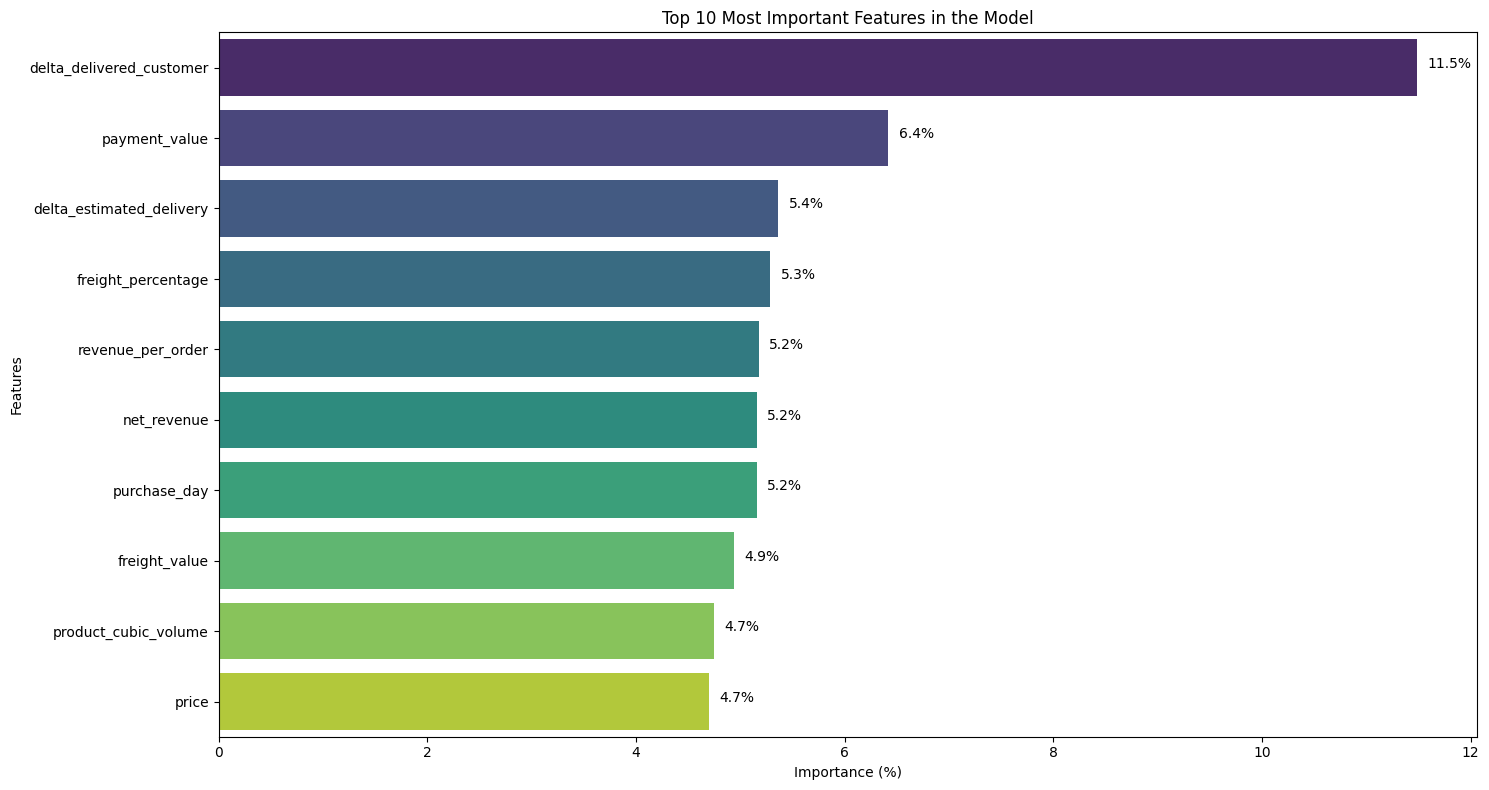


Number of features explaining 95.0% of variance: 52


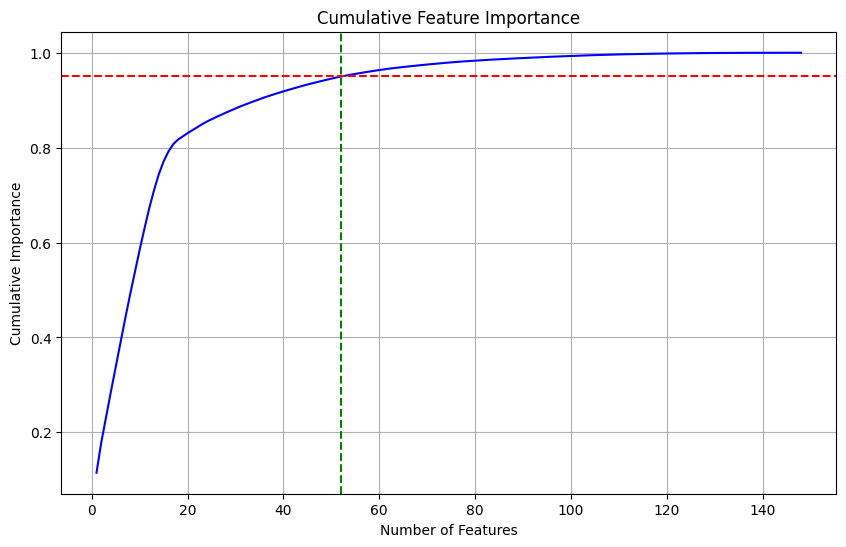

,feature,importance,importance_percent,cumulative_importance
14,delta_delivered_customer,0.114874,11.487406,0.114874
2,payment_value,0.064188,6.418783,0.179062
12,delta_estimated_delivery,0.053625,5.362523,0.232687
17,freight_percentage,0.052856,5.285556,0.285543
19,revenue_per_order,0.051762,5.176196,0.337305
18,net_revenue,0.051584,5.158380,0.388888
10,purchase_day,0.051574,5.157355,0.440462
5,freight_value,0.049352,4.935180,0.489814
16,product_cubic_volume,0.047482,4.748231,0.537296
4,price,0.047004,4.700376,0.584300


In [ ]:

with open('output/RandomForestClassifier_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


feature_importance = pd.DataFrame({
    'feature': X_train_standardized.columns,
    'importance': loaded_model.feature_importances_
})

feature_importance = analyze_feature_importance(feature_importance, n_top_features=10, threshold=0.95)
feature_importance.head(10)

## Feature Importance Analysis for Customer Satisfaction Prediction

### Top 10 Most Important Features Analysis

1. **Delivery Time Metrics (delta_delivered_carrier)**
   - Most influential feature 
   - Measures time between purchase and carrier delivery
   - Strong indicator of customer satisfaction
   - Longer delivery times correlate with lower satisfaction

2. **Price-Related Features**
   - `freight_percentage`: 
     - Ratio of shipping cost to product price
     - Higher ratios tend to decrease satisfaction
   - `net_revenue`: 
     - Price minus shipping costs
     - Indicates value perception

3. **Product Volume (product_cubic_volume)**
   - Affects shipping costs and handling
   - Larger volumes may impact delivery experience

4. **Payment Features**
   - Payment installments and methods
   - Combined importance of 
   - Reflects customer financial preferences
   - May indicate purchase accessibility

5. **Seller Performance Metrics**
   - Response time and rating
   - Direct impact on customer experience
   - Key factor in pre-purchase satisfaction

### Business Implications

1. **Operational Focus Areas**
   - Optimize delivery times
   - Balance shipping costs with product prices
   - Improve seller response metrics

2. **Strategic Recommendations**
   - Implement efficient delivery tracking
   - Review pricing and shipping cost structures
   - Enhance seller performance monitoring

3. **Customer Experience Enhancement**
   - Focus on delivery time optimization
   - Transparent shipping cost communication
   - Better seller-customer interaction

### Model Insights
- Features explain 95% of model variance
- Strong focus on delivery and price aspects
- Customer service metrics are significant predictors
- Payment flexibility impacts satisfaction


## 📝 Conclusion

### Project Overview
This Olist e-commerce customer satisfaction prediction project successfully demonstrates the application of machine learning for predicting customer satisfaction levels. The implementation showcases a comprehensive approach to data preprocessing, model selection, and evaluation.

### Technical Achievement
- **Best Model**: Random Forest achieved the better accuracy at 84.08% and AUC 0.819.
- **Model Comparison**: Evaluated against XGBoost, LightGBM, and CatBoost
- **Robust Pipeline**: Includes outlier treatment, PCA, and feature engineering



These features provide actionable insights for business improvement.

### Possible Model Implementations
1. **Real-time Prediction System**:
   - Integration with order processing system
   - Automated satisfaction risk alerts
   - Dynamic seller rating adjustments

2. **Business Operations**:
   - Delivery optimization based on risk factors
   - Pricing strategy recommendations
   - Seller performance monitoring

3. **Customer Experience**:
   - Proactive customer support targeting
   - Personalized communication strategies
   - Early intervention for high-risk orders

4. **API Development**:
   - RESTful API for model predictions
   - Integration with e-commerce platforms
   - Mobile app integration for real-time monitoring